In [1]:
import pandas as pd
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import concurrent.futures
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV, KFold, LeaveOneOut
from datetime import timedelta

In [2]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)  

In [3]:
df = pd.read_parquet('COMPRESSED_CIS_tle_data.parquet')
df.shape

(3030409, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030409 entries, 0 to 3030408
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   idElset                object 
 1   classificationMarking  object 
 2   satNo                  int64  
 3   epoch                  object 
 4   meanMotion             float64
 5   idOnOrbit              object 
 6   eccentricity           float64
 7   inclination            float64
 8   raan                   float64
 9   argOfPerigee           float64
 10  meanAnomaly            float64
 11  revNo                  int64  
 12  bStar                  float64
 13  meanMotionDot          float64
 14  meanMotionDDot         float64
 15  semiMajorAxis          float64
 16  period                 float64
 17  apogee                 float64
 18  perigee                float64
 19  line1                  object 
 20  line2                  object 
 21  createdAt              object 
 22  createdBy         

**Describe the fields:**

0. idElset: A unique identifier for each satellite element set. Object data type.

1. classificationMarking: Indicates the classification of the satellite data, where "U" stands for unclassified. Object data type.

2. satNo: The satellite number, a unique identifier for a satellite. Interger data type.

3. epoch: The timestamp indicating when the satellite's position and orbital elements were recorded. This is in UTC format. Currently as object data type.

4. meanMotion: The number of revolutions the satellite completes around the earth per day. This parameter gives an idea of the speed at which the satellite orbits the earth. 64-bit floating-point number.

5. idOnOrbit: A repeat of the satellite number (satNo), possibly for consistency across different data sources. Object data type.

6. eccentricity: A measure of how much the satellite's orbit deviates from a perfect circle. Values closer to 0 indicate a more circular orbit, while values closer to 1 indicate a more elliptical orbit. 64-bit floating-point number.

7. inclination: The angle between the satellite's orbital plane and the Earth's equator, measured in degrees. It indicates how far north or south the satellite travels relative to the equator. 64-bit floating-point number.

8. raan (Right Ascension of the Ascending Node): The angle, measured from a fixed point in the sky, representing where the satellite crosses the equator from the southern hemisphere to the northern hemisphere. 64-bit floating-point number.

9. argOfPerigee (Argument of Perigee): The angle within the satellite's orbital plane that defines the point where the satellite is closest to the Earth (perigee). 64-bit floating-point number.

10. meanAnomaly: An angular parameter that helps describe the position of the satellite along its orbit at a specific time. 64-bit floating-point number.

11. revNo: The revolution number of the satellite, indicating the number of complete orbits made by the satellite since launch. An interger data type.

12. bStar: A drag term used in the satellite's orbital model to account for atmospheric drag affecting the satellite’s motion, particularly in lower orbits. 64-bit floating-point number.

13. meanMotionDot: The first derivative of the mean motion, representing how the satellite’s speed is changing over time, which might be due to perturbing forces like gravitational effects. 64-bit floating-point number.

14. meanMotionDDot: The second derivative of the mean motion, further describing changes in the satellite’s speed, providing more detailed information about the satellite's acceleration or deceleration. 64-bit floating-point number.

15. semiMajorAxis: The distance from the center of the satellite's orbit to its farthest point, measured in kilometers. This value is important for describing the size of the satellite's orbit. 64-bit floating-point number.

16. period: The time it takes for the satellite to complete one full orbit around the Earth, measured in minutes. 64-bit floating-point number.

17. apogee: The highest point in the satellite's orbit, i.e., the farthest distance from the Earth during its orbit. 64-bit floating-point number.

18. perigee: The lowest point in the satellite's orbit, i.e., the closest distance to the Earth during its orbit. 64-bit floating-point number.

19. line1: A string representing the first line of a Two-Line Element (TLE) format, which contains information about the satellite's orbit. Object data type.

20. line2: A string representing the second line of a TLE format, which includes additional details about the satellite's orbital elements. Object data type.

21. createdAt: The timestamp indicating when this specific record or data entry was created. Object data type.

22. createdBy: The identifier for the system or person responsible for generating this specific record. Object data type.

23. source: The organization or system that provided the satellite data. In this case, "18th SPCS" refers to the 18th Space Control Squadron, which tracks space objects. Object data type.

24. dataMode: Describes the type or mode of data being used or collected. For example, 'REAL' might indicate real-time or current data. Object data type.

25. origNetwork: Likely identifies the network or system through which the data was originally collected or processed. Object data type.

26. algorithm: The algorithm used to process or analyze the satellite data. In this case, 'SGP4' refers to the Simplified General Perturbations model, which is a commonly used orbital model for predicting satellite positions. Object data type.

27. sourceDL: Possibly refers to additional details or metadata about the data source, though it’s marked as None in the provided example. Object data type.

28. ephemType: Likely refers to the type of ephemeris (data that provides the positions of astronomical objects), though it is marked as NaN in this example. 64-bit floating-point number. 

29. uct: May refer to Universal Coordinated Time (UTC), though this column is marked as None in the example provided. Object data type.

30. descriptor: Additional descriptive information about the satellite or data, though it is marked as None in this case. Object data type.

In [11]:
# Load the CIS_satcat.pkl dataset
file_path = r'C:\Users\megan\OneDrive\Desktop\Data_Analytics\CIS 831A\Project\CIS831_russat-main\output\CIS_satcat.pkl'

with open(file_path, 'rb') as f:
    satcat = pickle.load(f)

# Convert the satcat data into a DataFrame for easy manipulation
satcat_df = pd.DataFrame(satcat)

# Load the UCS-Satellite-Database 5-1-2023.xlsx dataset
file_path_ucs = r'C:\Users\megan\OneDrive\Desktop\Data_Analytics\CIS 831A\Project\CIS831_russat-main\notebooks\UCS-Satellite-Database 5-1-2023.xlsx'
ucs_df = pd.read_excel(file_path_ucs)

# Ensure 'NORAD_CAT_ID' and 'satNo' are the same type, converting both to integers
satcat_df['NORAD_CAT_ID'] = satcat_df['NORAD_CAT_ID'].astype(int)
df['satNo'] = df['satNo'].astype(int)
ucs_df['NORAD Number'] = ucs_df['NORAD Number'].astype(int)

# Merge the original dataset with the enriched data from 'satcat_df' and 'ucs_df'
# Only keep relevant fields from each additional dataset
df = pd.merge(df, satcat_df[['NORAD_CAT_ID', 'COUNTRY', 'OBJECT_TYPE']], 
              how='left', left_on='satNo', right_on='NORAD_CAT_ID')
df = pd.merge(df, ucs_df[['NORAD Number', 'Country of Operator/Owner', 'Purpose']],
              how='left', left_on='satNo', right_on='NORAD Number')

# Filter to include only 'CIS' country and 'ROCKET BODY' or 'PAYLOAD'
filtered_df = df[(df['COUNTRY'] == 'CIS') & 
                 (df['OBJECT_TYPE'].isin(['PAYLOAD'])) & 
                 (df['Country of Operator/Owner'] == 'Russia')]

# Remove any duplicate rows
filtered_df = filtered_df.drop_duplicates()

# Display the filtered data to ensure it worked
filtered_df.head()

idElset classificationMarking  satNo                        epoch  meanMotion idOnOrbit  eccentricity  inclination     raan  argOfPerigee  meanAnomaly  revNo     bStar  meanMotionDot  meanMotionDDot  semiMajorAxis  period    apogee   perigee                                              line1                                              line2                 createdAt         createdBy     source dataMode origNetwork algorithm sourceDL  ephemType   uct descriptor  NORAD_CAT_ID COUNTRY OBJECT_TYPE  NORAD Number Country of Operator/Owner            Purpose
3559  0b412702-831c-41ee-91d0-cc979d976624                     U  41386  2023-10-14T12:05:14.817408Z   15.824571     41386      0.000294      97.1681  19.3954       43.0285     317.1214  42564  0.000537       0.001123             0.0       6701.631  90.998  6703.602  6699.661  1 41386U 16016A   23287.50364372 +.00112296 +0...  2 41386  97.1681  19.3954 0002941  43.0285 317...  2023-10-14T15:05:13.210Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         41386     CIS     PAYLOAD       41386.0                    Russia  Earth Observation
3560  61756d40-0547-40d0-9e00-7f291a1f3b8f                     U  41386  2023-10-17T06:51:10.448640Z   15.829922     41386      0.000294      97.1662  22.2995       32.3604     327.7846  42608  0.000420       0.000898             0.0       6700.121  90.967  6702.088  6698.154  1 41386U 16016A   23290.28553760 +.00089823 +0...  2 41386  97.1662  22.2995 0002936  32.3604 327...  2023-10-17T15:05:13.931Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         41386     CIS     PAYLOAD       41386.0                    Russia  Earth Observation
3561  c41c9a71-531f-4d2a-a941-914860e700a9                     U  41386  2023-10-15T21:28:22.646784Z   15.827299     41386      0.000291      97.1670  20.8475       37.2314     322.9157  42586  0.000462       0.000976             0.0       6700.862  90.982  6702.809  6698.914  1 41386U 16016A   23288.89470656 +.00097587 +0...  2 41386  97.1670  20.8475 0002906  37.2314 322...  2023-10-16T03:05:12.361Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         41386     CIS     PAYLOAD       41386.0                    Russia  Earth Observation
3562  5b704b78-43c0-43e2-8b3a-b943d94a97c8                     U  41386  2023-10-16T05:03:35.242848Z   15.827951     41386      0.000289      97.1668  21.1774       37.1818     322.9650  42591  0.000480       0.001017             0.0       6700.677  90.978  6702.611  6698.744  1 41386U 16016A   23289.21082457 +.00101733 +0...  2 41386  97.1668  21.1774 0002886  37.1818 322...  2023-10-16T07:05:11.881Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         41386     CIS     PAYLOAD       41386.0                    Russia  Earth Observation
3563  44b259ee-a77d-4a8e-b88e-094db020ca08                     U  41386  2023-10-16T08:05:40.009632Z   15.828164     41386      0.000290      97.1667  21.3096       37.0084     323.1385  42593  0.000460       0.000976             0.0       6700.617  90.977  6702.560  6698.674  1 41386U 16016A   23289.33726863 +.00097644 +0...  2 41386  97.1667  21.3096 0002900  37.0084 323...  2023-10-16T10:05:12.326Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         41386     CIS     PAYLOAD       41386.0                    Russia  Earth Observation

In [12]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147349 entries, 3559 to 3023033
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   idElset                    147349 non-null  object 
 1   classificationMarking      147349 non-null  object 
 2   satNo                      147349 non-null  int32  
 3   epoch                      147349 non-null  object 
 4   meanMotion                 147349 non-null  float64
 5   idOnOrbit                  147349 non-null  object 
 6   eccentricity               147349 non-null  float64
 7   inclination                147349 non-null  float64
 8   raan                       147349 non-null  float64
 9   argOfPerigee               147349 non-null  float64
 10  meanAnomaly                147349 non-null  float64
 11  revNo                      147349 non-null  int64  
 12  bStar                      147349 non-null  float64
 13  meanMotionDot              147

In [13]:
# Filter filtered_df to include only rows where Purpose is "Navigation/Global Positioning"
RU_PNT_SAT = filtered_df[filtered_df['Purpose'] == "Navigation/Global Positioning"]

# Display the filtered data to ensure it worked
RU_PNT_SAT.head()

idElset classificationMarking  satNo                        epoch  meanMotion idOnOrbit  eccentricity  inclination      raan  argOfPerigee  meanAnomaly  revNo  bStar  meanMotionDot  meanMotionDDot  semiMajorAxis   period     apogee    perigee                                              line1                                              line2                 createdAt         createdBy     source dataMode origNetwork algorithm sourceDL  ephemType   uct descriptor  NORAD_CAT_ID COUNTRY OBJECT_TYPE  NORAD Number Country of Operator/Owner                        Purpose
29711  f58e360e-ebee-43c5-a331-84148e1d4801                     U  29671  2024-01-21T00:52:42.563136Z    2.129632     29671      0.002103      64.7108  223.7708      176.0106     185.7700  13285    0.0   1.120000e-06             0.0      25519.108  676.173  25572.772  25465.444  1 29671U 06062B   24021.03660374 +.00000112 +0...  2 29671  64.7108 223.7708 0021029 176.0106 185...  2024-01-21T18:05:13.637Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning
29712  37a0b758-503f-40a4-85ac-8049aa5bdfcd                     U  29671  2024-09-30T08:13:07.427712Z    2.129633     29671      0.002142      64.7020  215.3159      179.3809     343.4896  13823    0.0  -2.700000e-07             0.0      25519.096  676.173  25573.768  25464.424  1 29671U 06062B   24274.34244708 -.00000027 +0...  2 29671  64.7020 215.3159 0021424 179.3809 343...  2024-09-30T15:05:26.985Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning
29713  3b689498-13b2-45fb-85bc-7aeeef7bf6b6                     U  29671  2024-09-28T08:47:51.707616Z    2.129633     29671      0.002143      64.7021  215.3817      179.4255     268.6067  13820    0.0  -2.800000e-07             0.0      25519.099  676.173  25573.784  25464.414  1 29671U 06062B   24272.36657069 -.00000028 +0...  2 29671  64.7021 215.3817 0021429 179.4255 268...  2024-09-28T19:05:12.963Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning
29714  10e31035-3336-42e1-a032-3933888a38aa                     U  29671  2024-09-26T14:38:55.265568Z    2.129633     29671      0.002146      64.7024  215.4402      179.5990       2.0077  13816    0.0  -1.000000e-07             0.0      25519.101  676.173  25573.857  25464.345  1 29671U 06062B   24270.61036187 -.00000010 +0...  2 29671  64.7024 215.4402 0021457 179.5990   2...  2024-09-27T03:05:17.489Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning
29715  f3a62707-bec3-4066-a468-064ac04a545e                     U  29671  2024-02-16T10:01:08.580288Z    2.129632     29671      0.002116      64.7100  222.8878      176.6581     250.4393  13341    0.0   9.400000e-07             0.0      25519.107  676.173  25573.100  25465.114  1 29671U 06062B   24047.41746042 +.00000094 +0...  2 29671  64.7100 222.8878 0021158 176.6581 250...  2024-02-16T18:05:13.117Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning

In [14]:
RU_PNT_SAT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10617 entries, 29711 to 2951509
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   idElset                    10617 non-null  object 
 1   classificationMarking      10617 non-null  object 
 2   satNo                      10617 non-null  int32  
 3   epoch                      10617 non-null  object 
 4   meanMotion                 10617 non-null  float64
 5   idOnOrbit                  10617 non-null  object 
 6   eccentricity               10617 non-null  float64
 7   inclination                10617 non-null  float64
 8   raan                       10617 non-null  float64
 9   argOfPerigee               10617 non-null  float64
 10  meanAnomaly                10617 non-null  float64
 11  revNo                      10617 non-null  int64  
 12  bStar                      10617 non-null  float64
 13  meanMotionDot              10617 non-null  fl

In [15]:
# Which satNo's are aligned to the Navigation/Global Positioning
RU_PNT_SAT['satNo'].value_counts()

satNo
41330    513
32393    408
44299    394
43687    394
32395    390
36111    385
44850    385
37139    383
36402    380
40001    378
42939    378
37867    378
45358    368
43508    364
40315    363
39155    362
54031    361
37869    359
36112    357
52984    357
36401    353
32275    352
46805    350
32276    349
37868    347
37372    344
29670    231
29671    222
36400    215
41554    197
Name: count, dtype: int64

## Regular Analytics Method

**Method:**

This example is designed to detect and visualize anomalies in satellite orbital data, focus on rates of change for seven key orbital features: semiMajorAxis, inclination, meanMotion, eccentricity, raan, argOfPerigee, and meanAnomaly. It identifies significant deviations in these features as potential indicators of satellite maneuvers, then visualizes and counts anomalies over time. During the previous step, I limited the data to just Russian Navigation/Global Positioning Payload data.

1. Define Rate of Change Calculation: A function calculate_rate_of_change computes the rate of change for each orbital feature by calculating the absolute difference between consecutive data points and dividing by the time difference in days. This function is applied to each feature to detect unusual changes over time.

2. Set Thresholds for Anomaly Detection: Threshold values are defined for each feature (e.g., semiMajorAxis, inclination, meanMotion, eccentricity, raan, argOfPerigee, and meanAnomaly). These thresholds determine what constitutes a significant rate of change, marking these instances as potential anomalies.

3. Group Data by Satellite: The dataset is grouped by each satellite ID (satNo), allowing the analysis to be conducted separately for each satellite.

4. Anomaly Detection Loop: For each satellite, the function calculates the rate of change for each feature and identifies any instances where the rate exceeds the defined thresholds. Detected anomalies for each feature are stored in a DataFrame for later analysis.

5. Visualize Data and Anomalies: Using subplots, each orbital feature is plotted separately for each satellite. Data points are displayed as scatter plots to avoid line clutter. Anomalous points are highlighted with red markers to distinguish them from normal data points. This visualization allows easy identification of trends and unusual behavior in each feature independently.

6. Combine and Return Anomalies: All detected anomalies across satellites are combined into a single DataFrame, which can be used for further analysis or reporting.

Processing satellite 29670


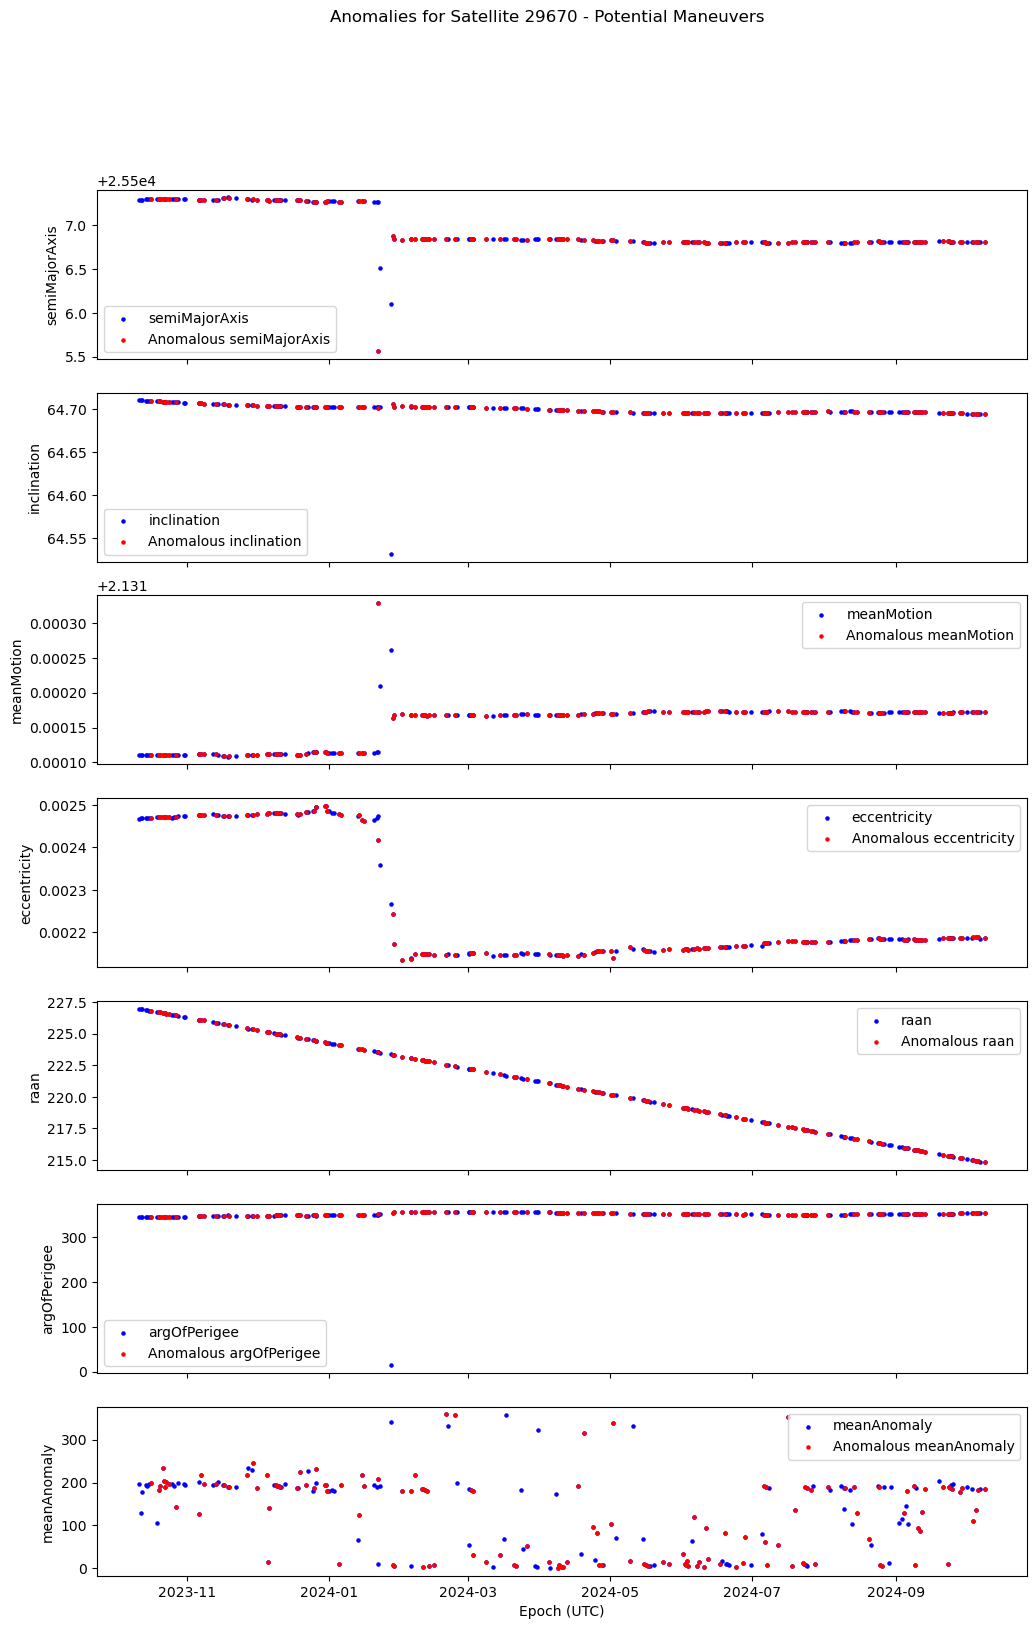

Processing satellite 29671


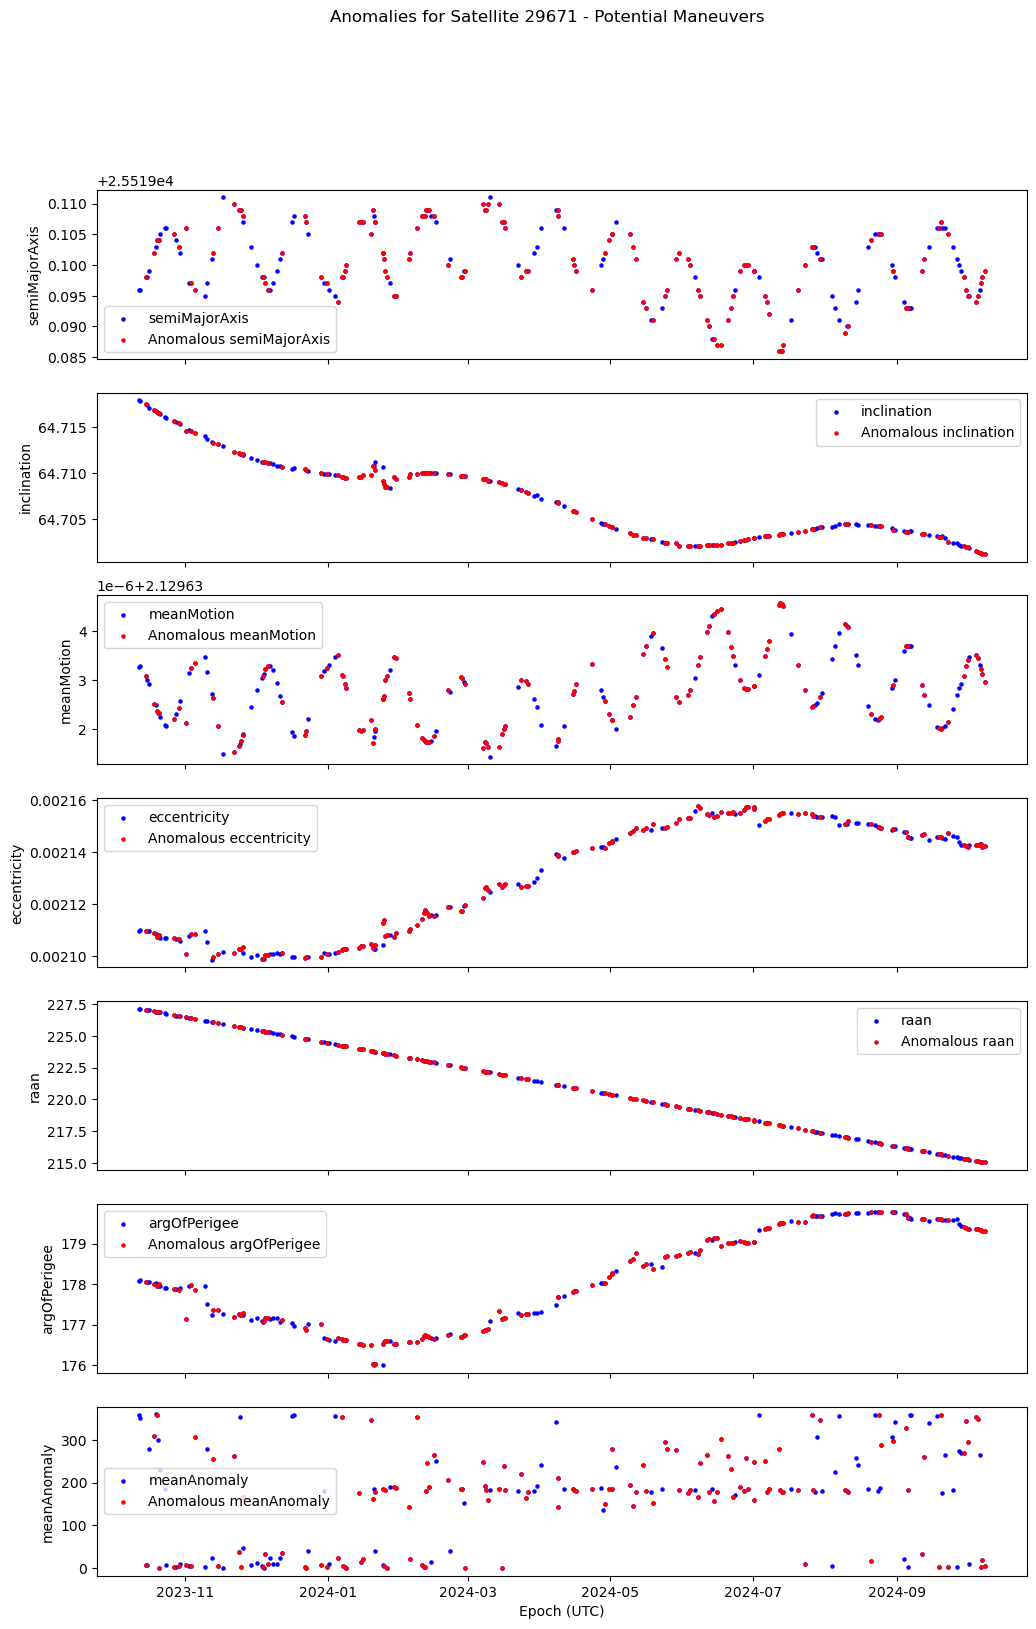

Processing satellite 32275


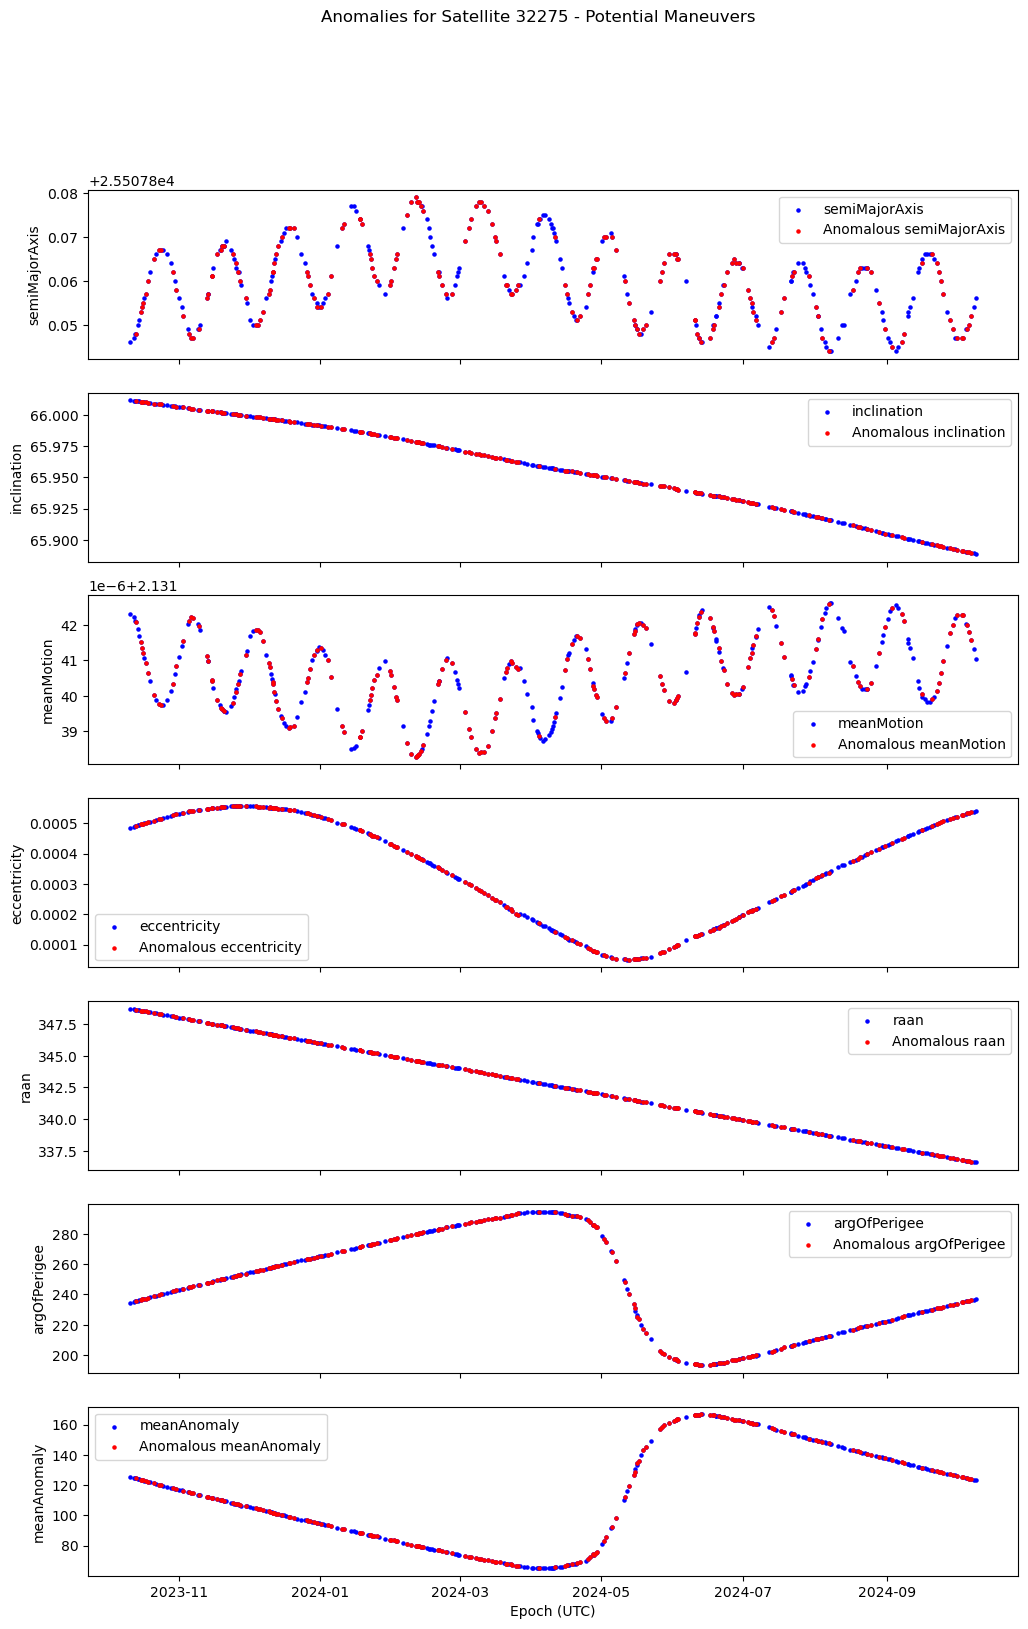

Processing satellite 32276


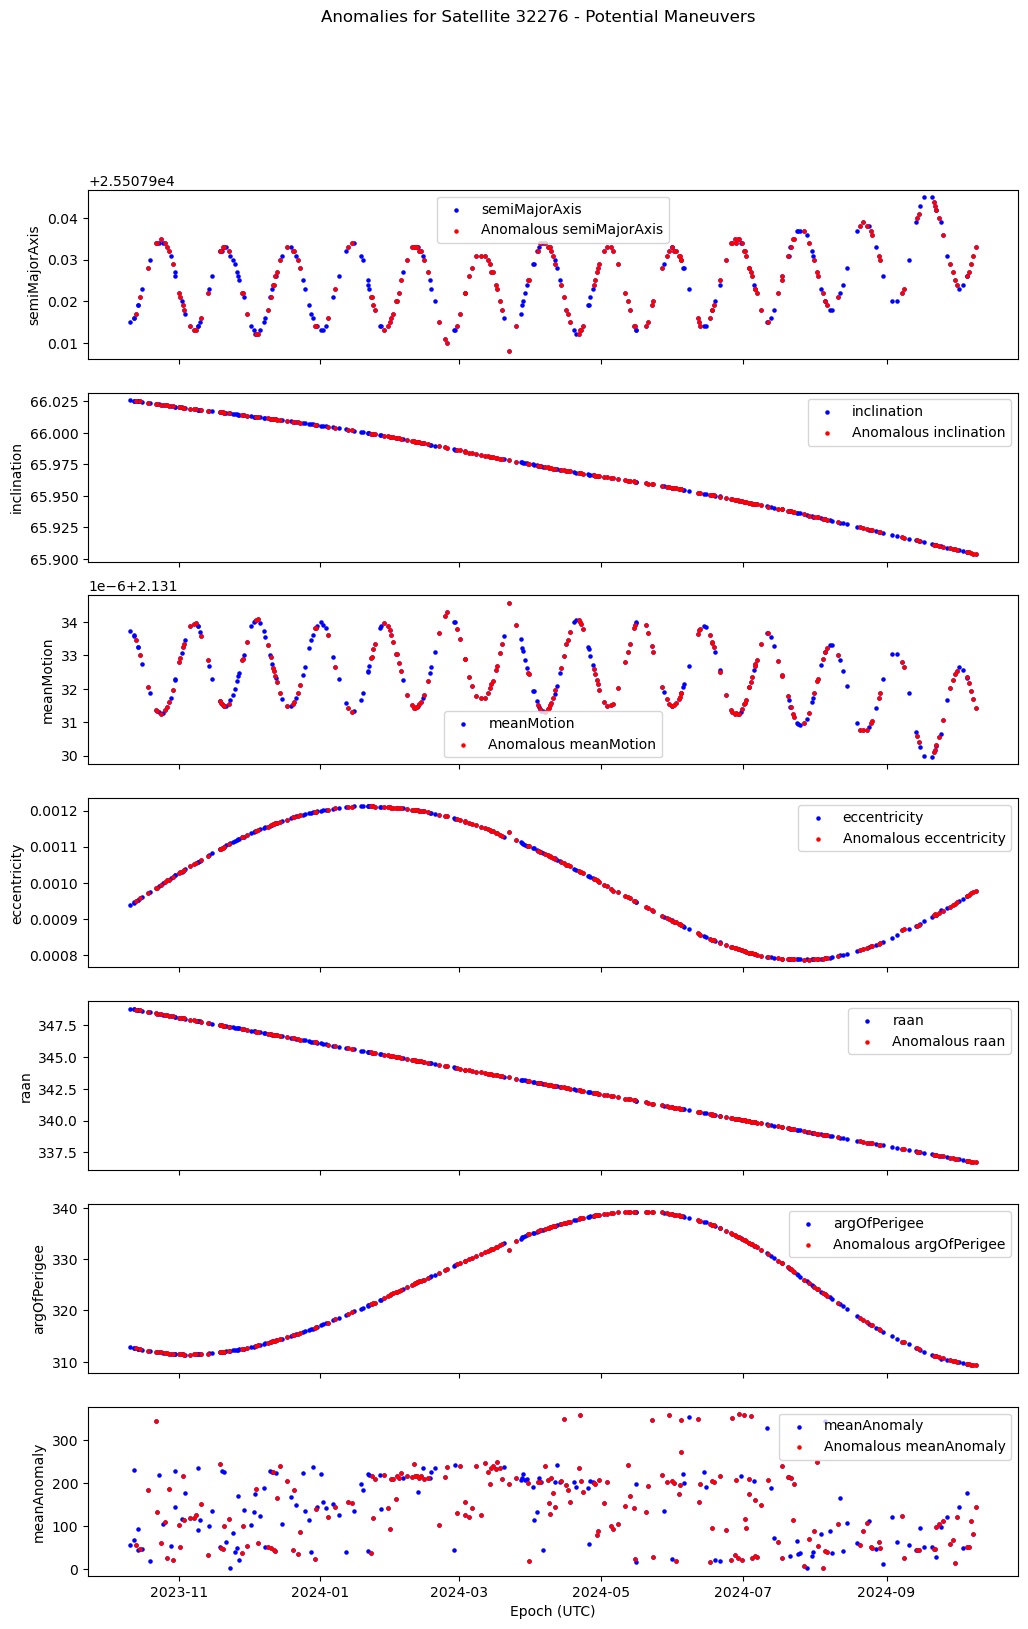

Processing satellite 32393


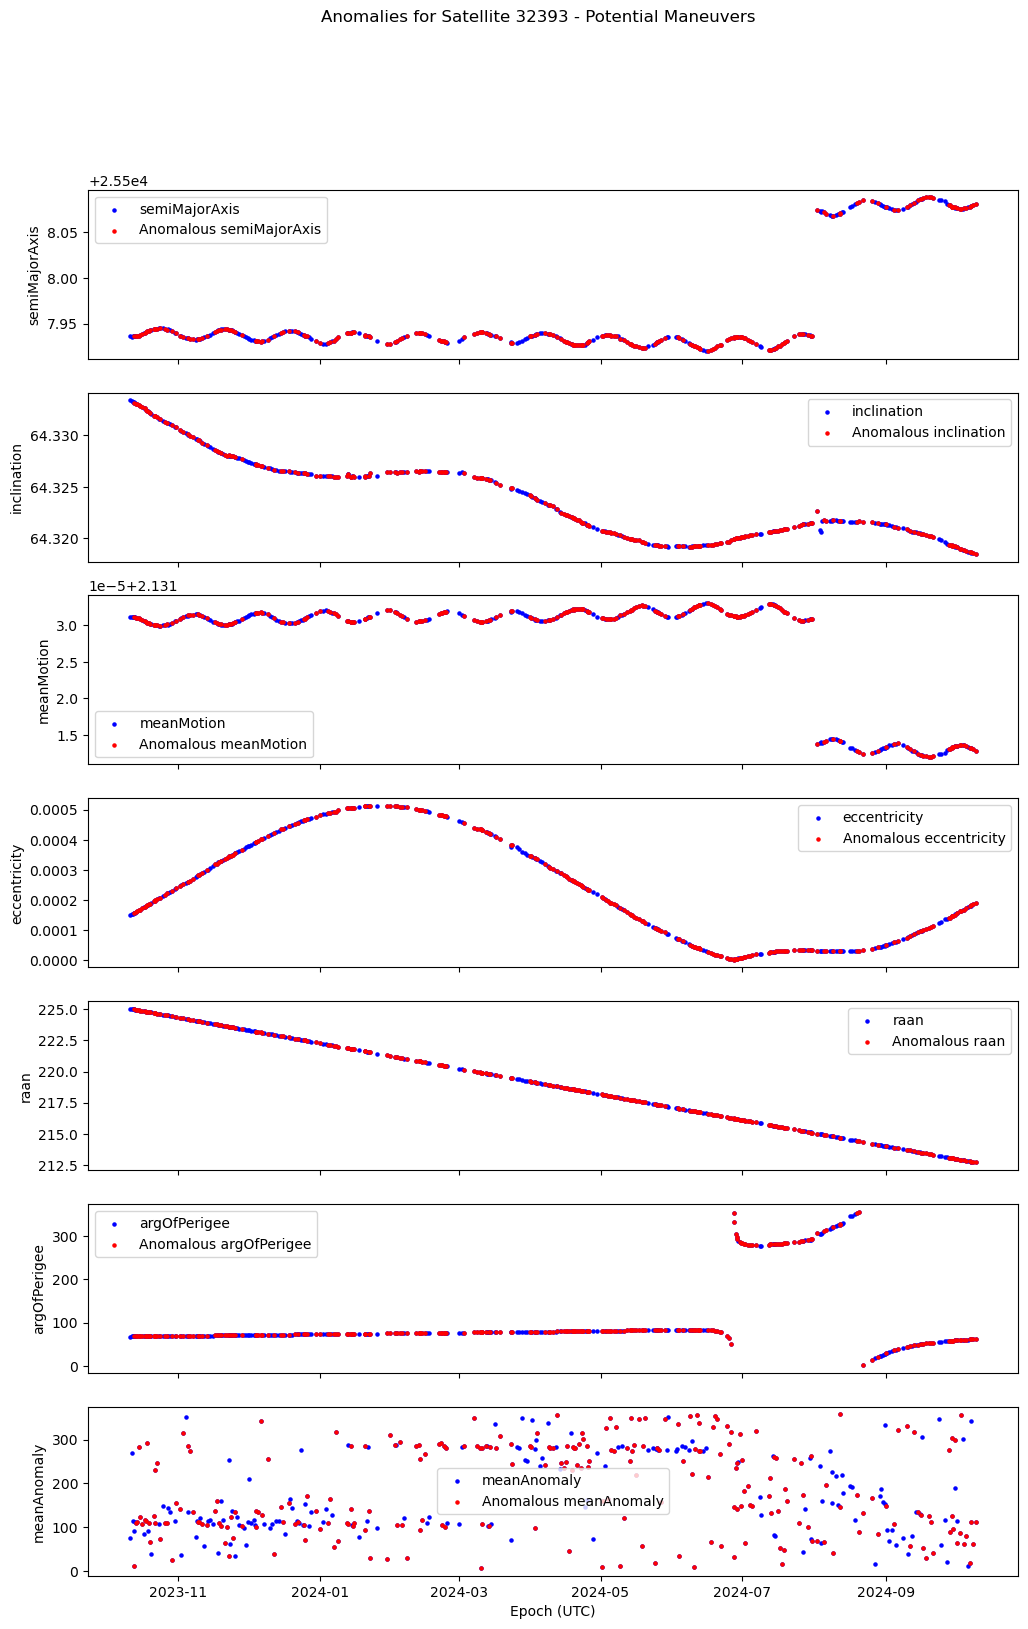

Processing satellite 32395


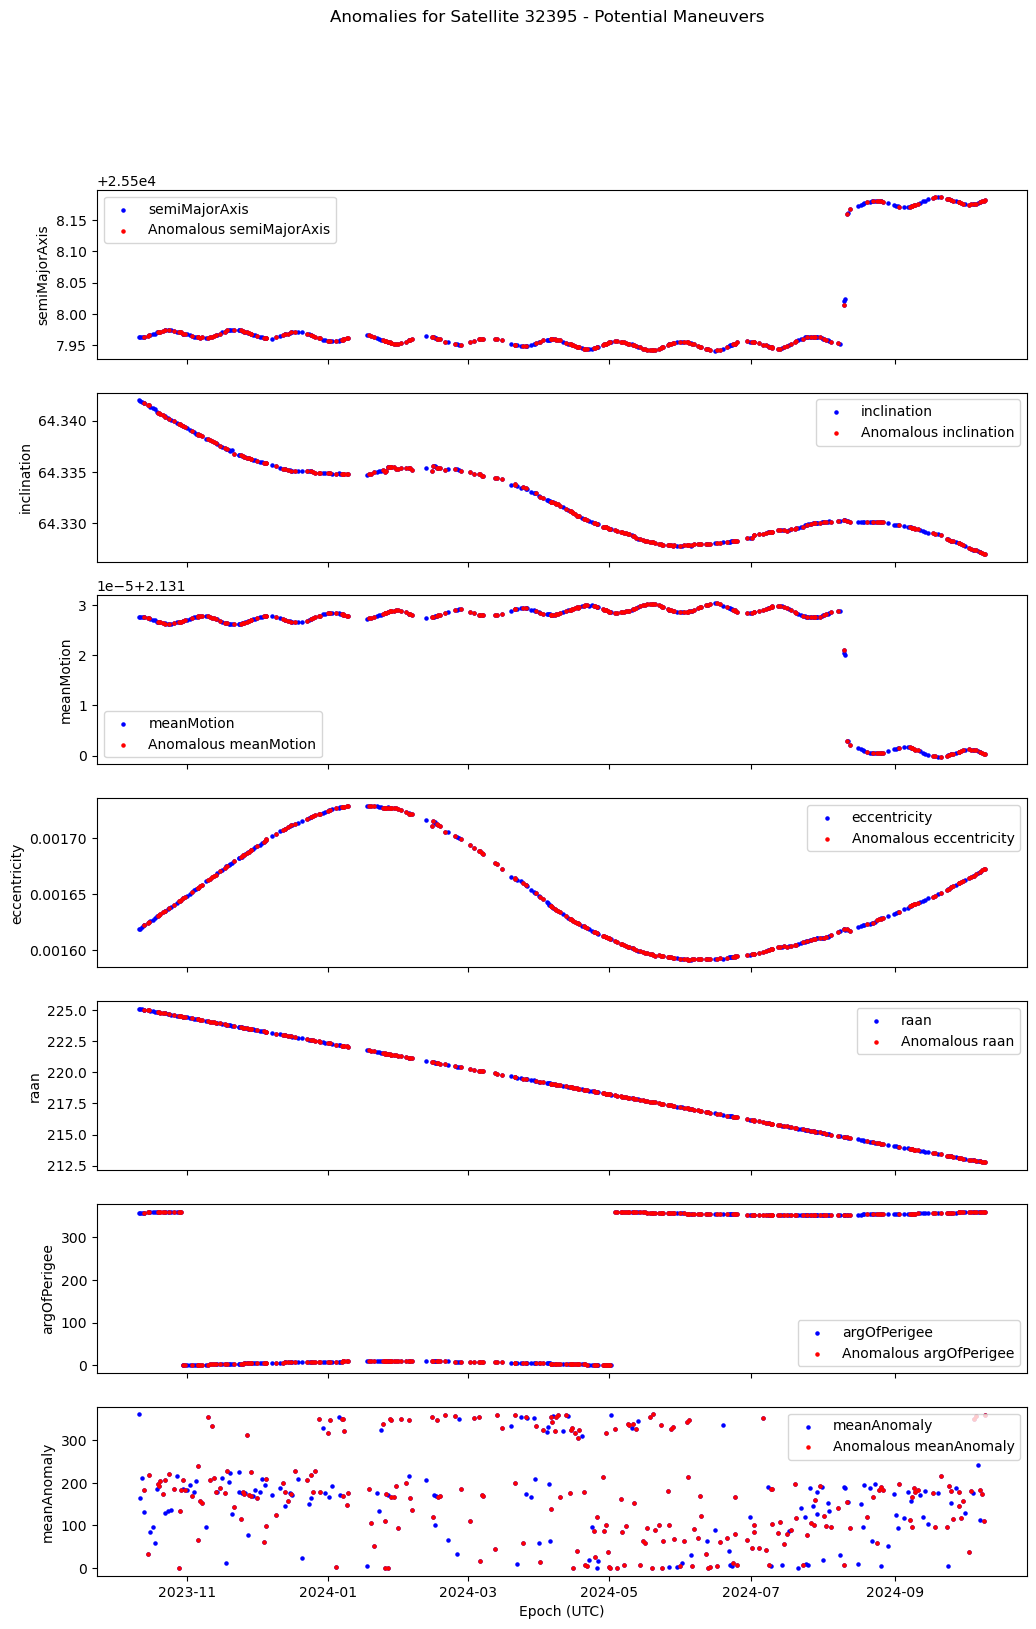

Processing satellite 36111


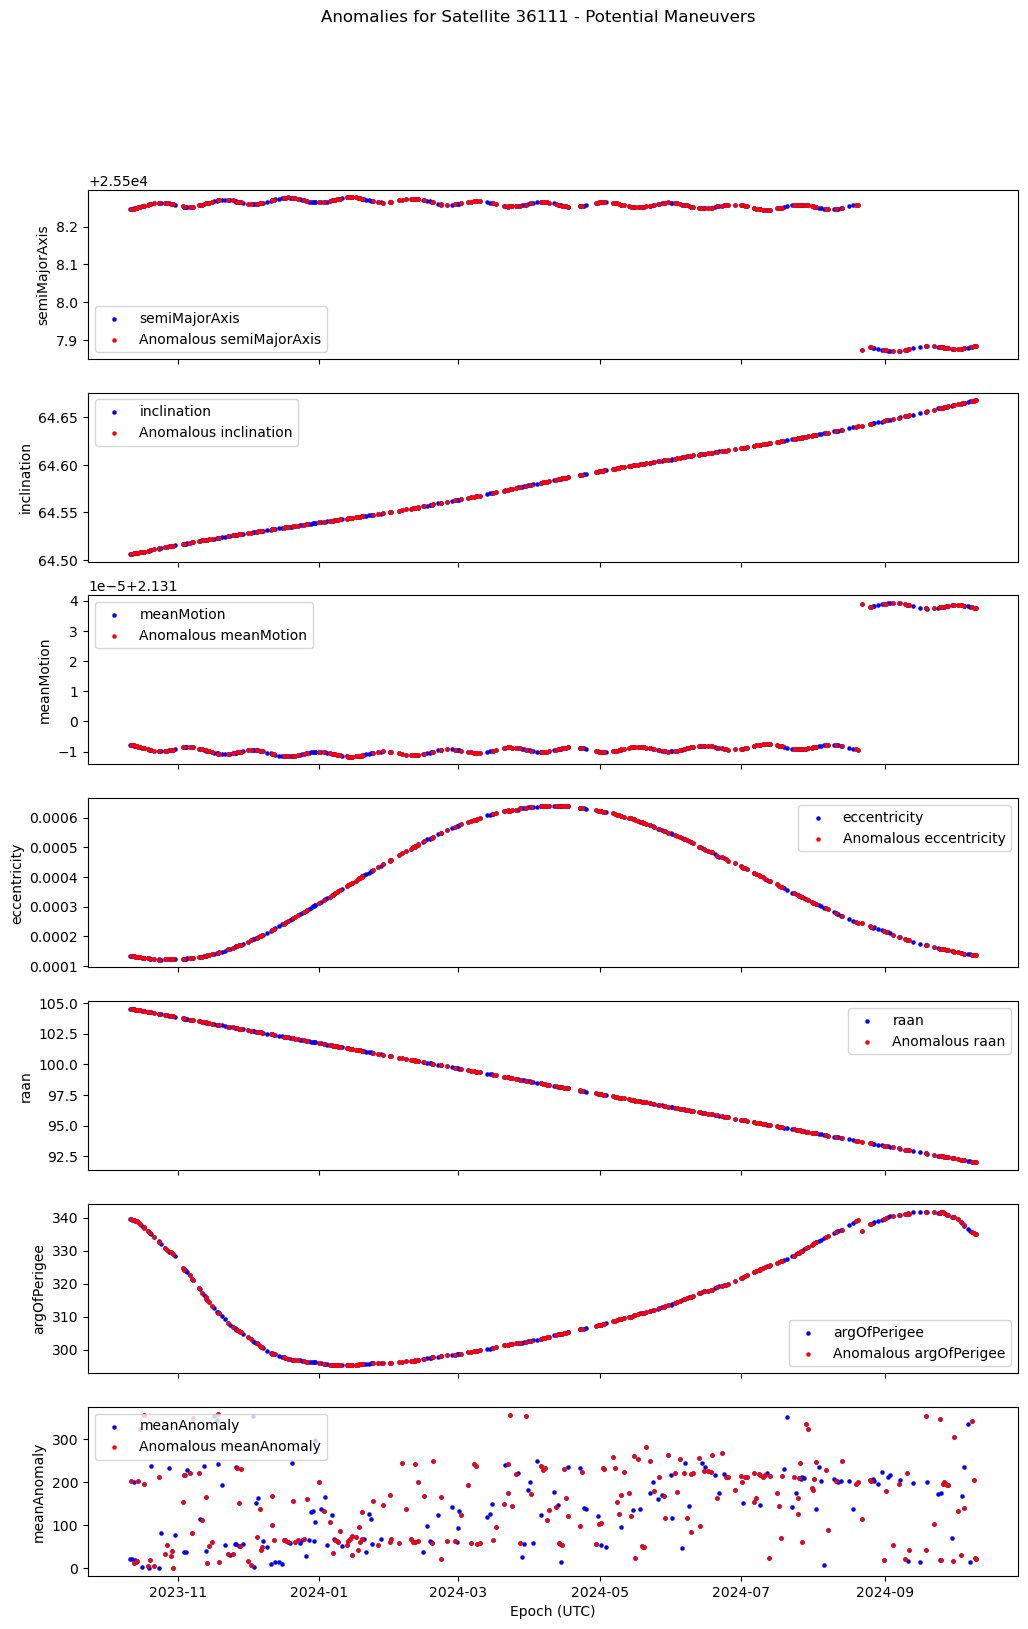

Processing satellite 36112


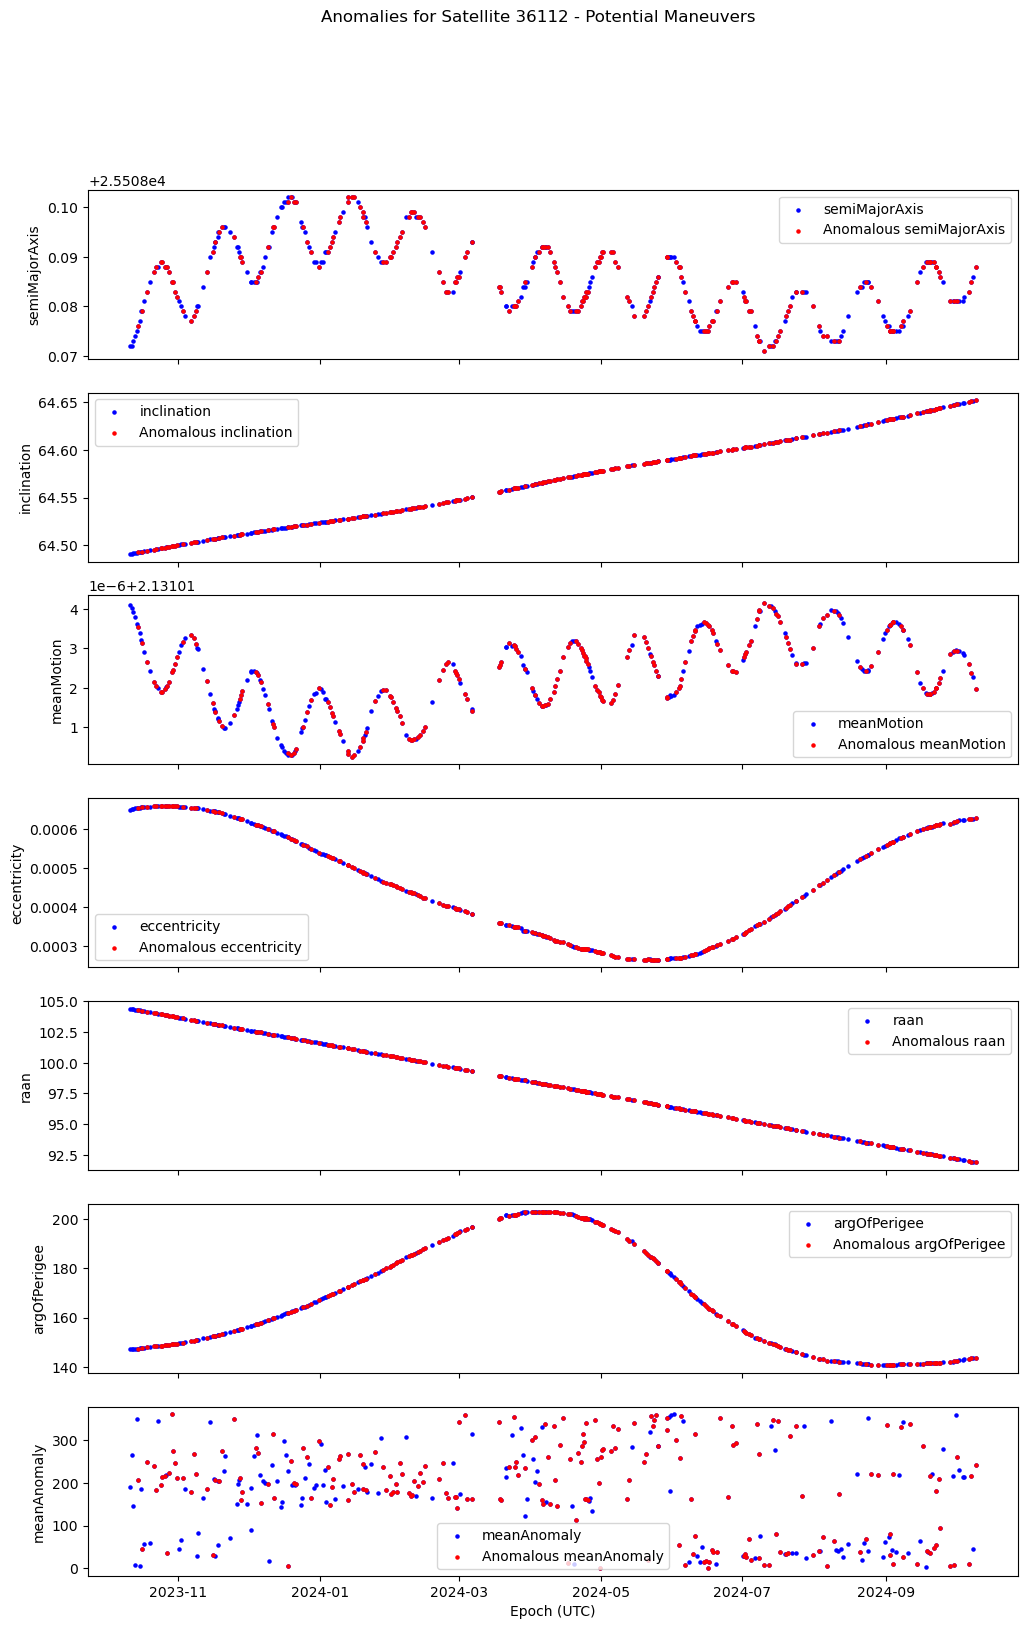

Processing satellite 36400


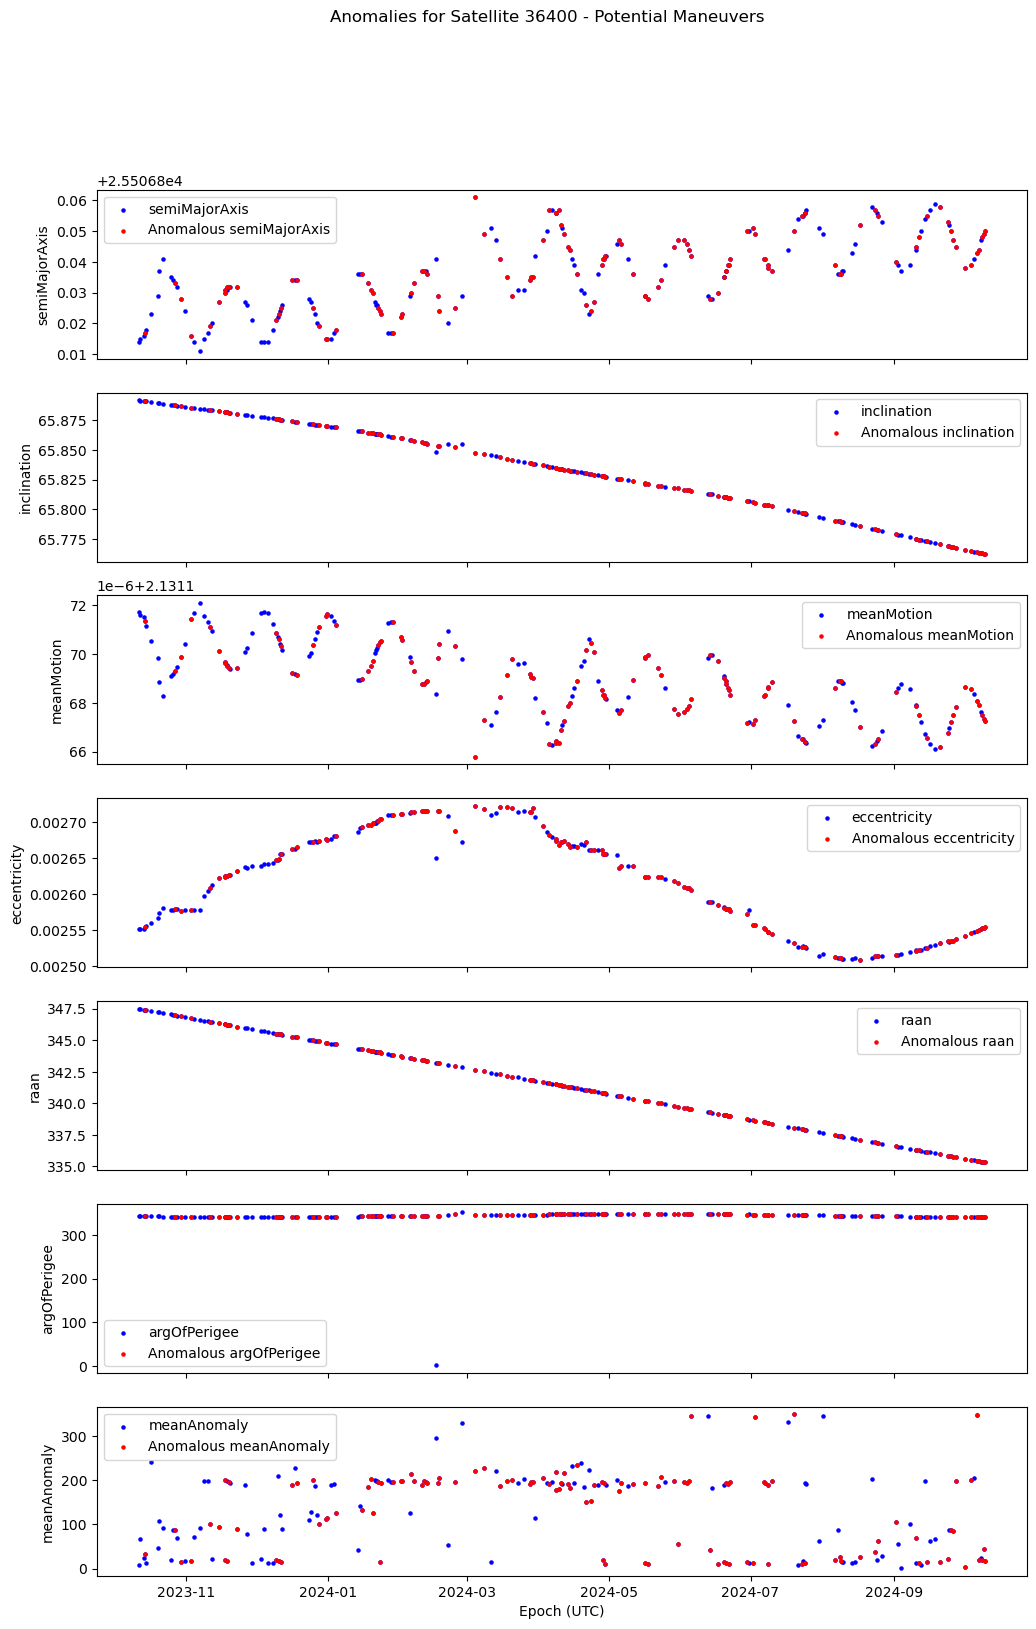

Processing satellite 36401


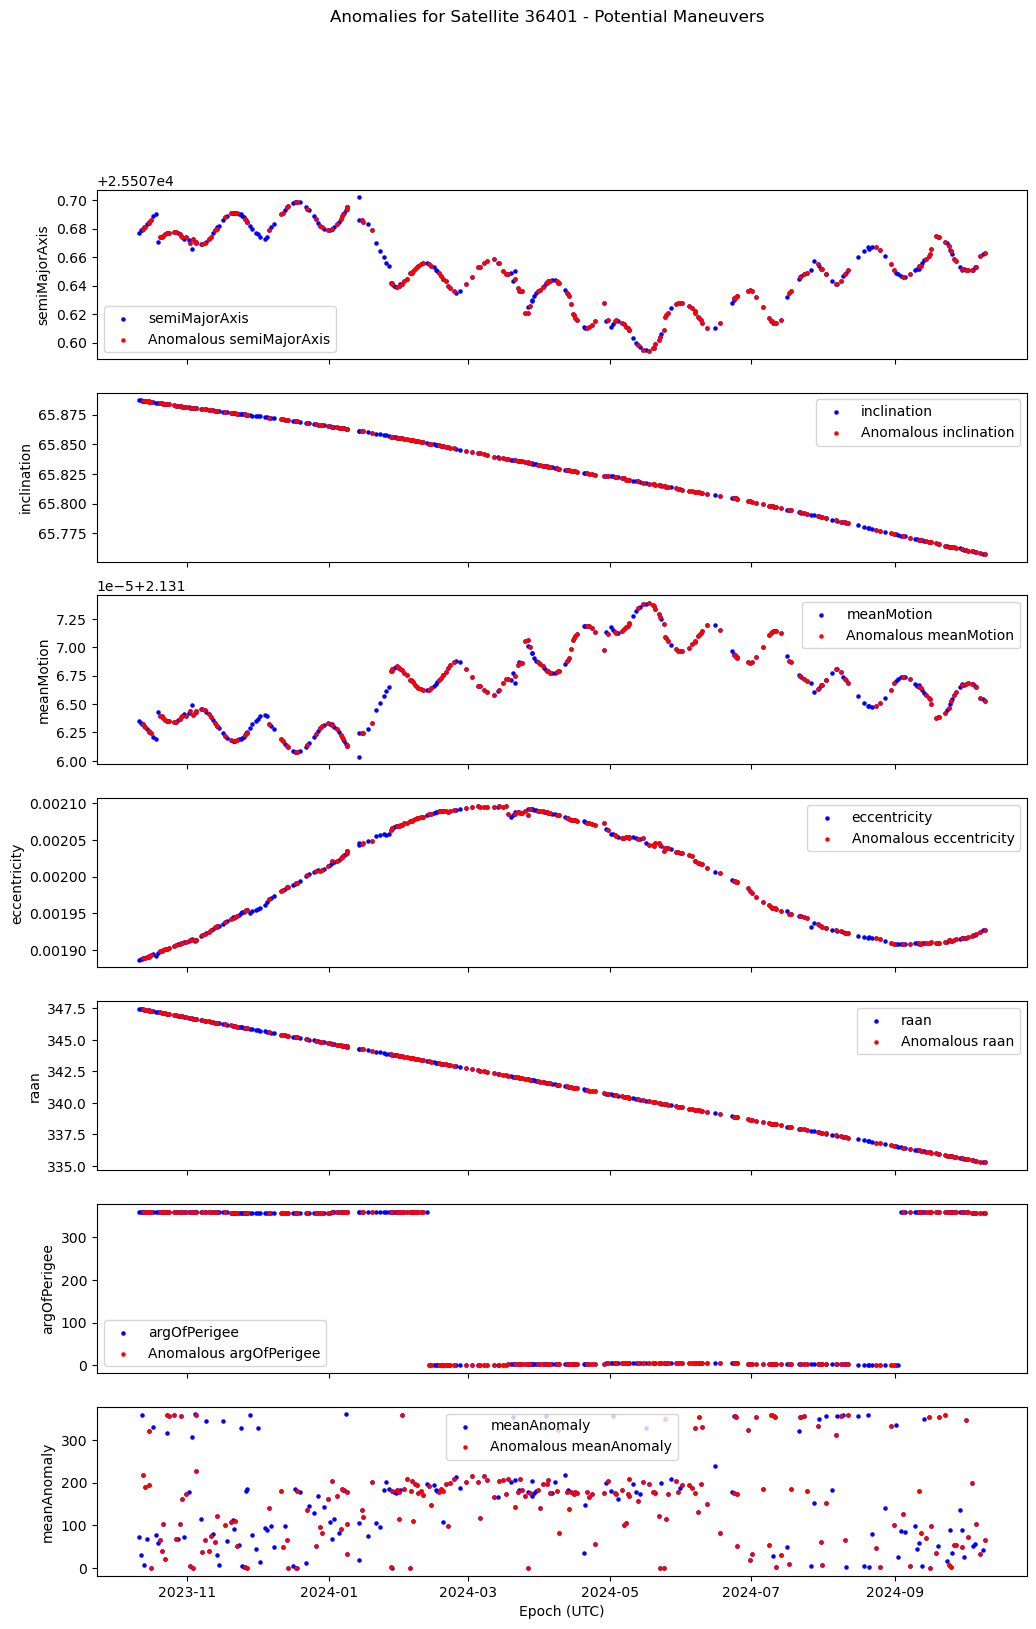

Processing satellite 36402


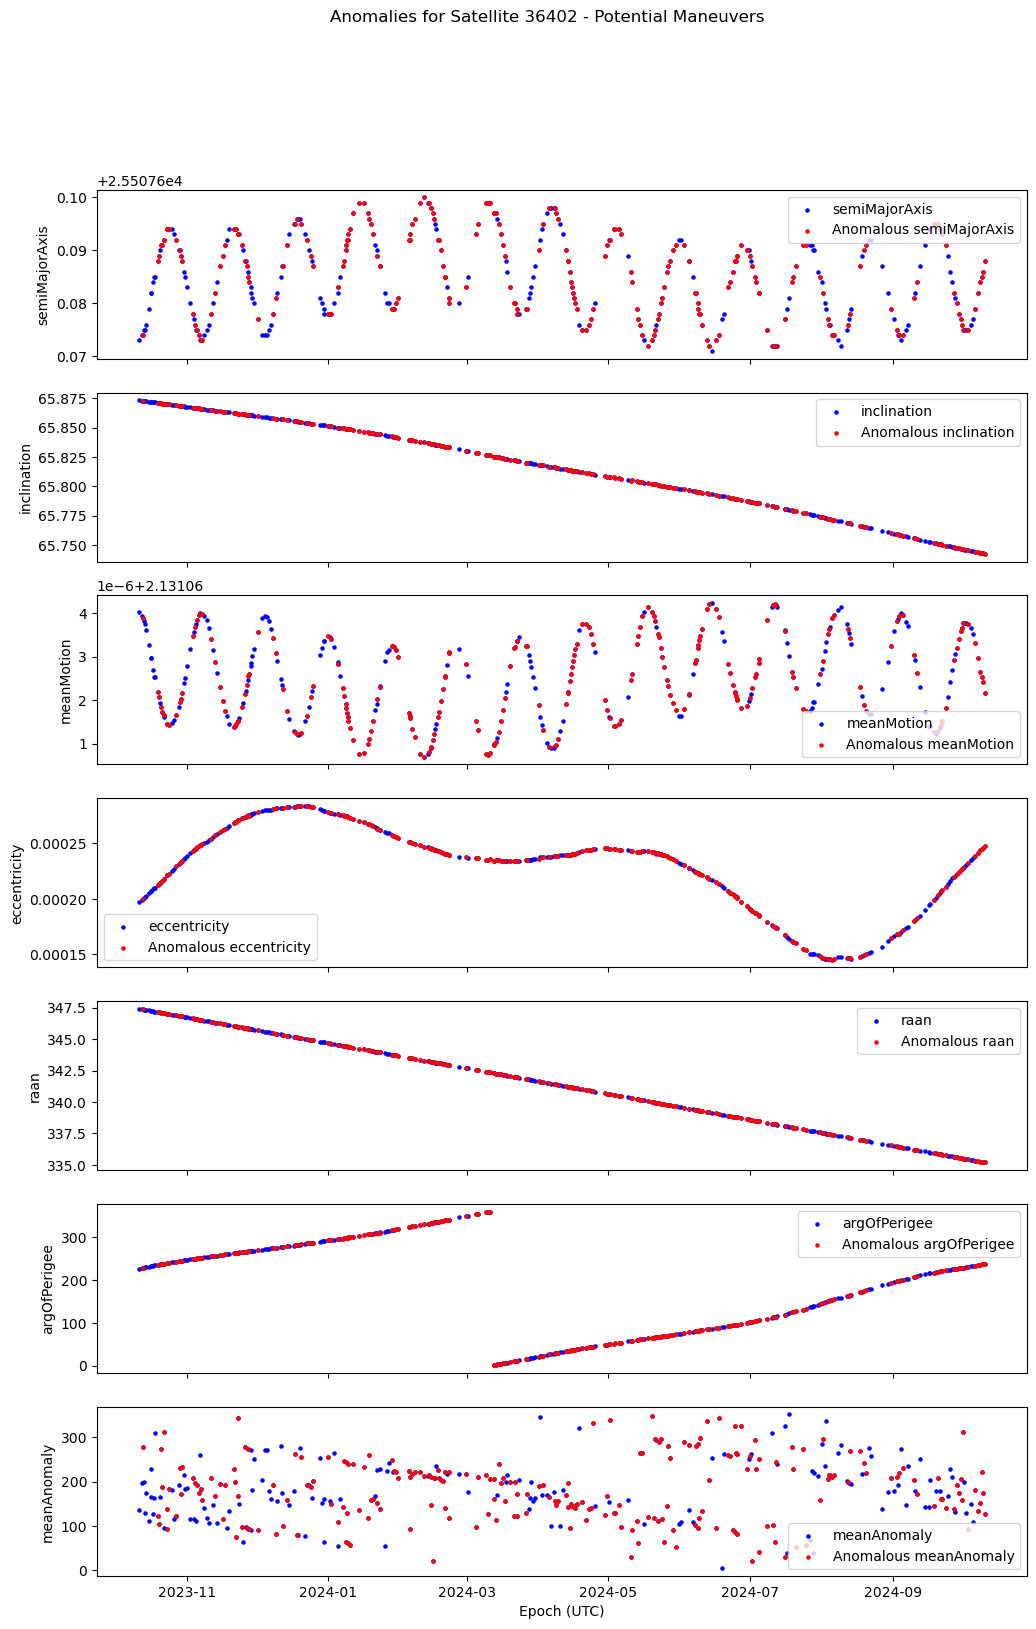

Processing satellite 37139


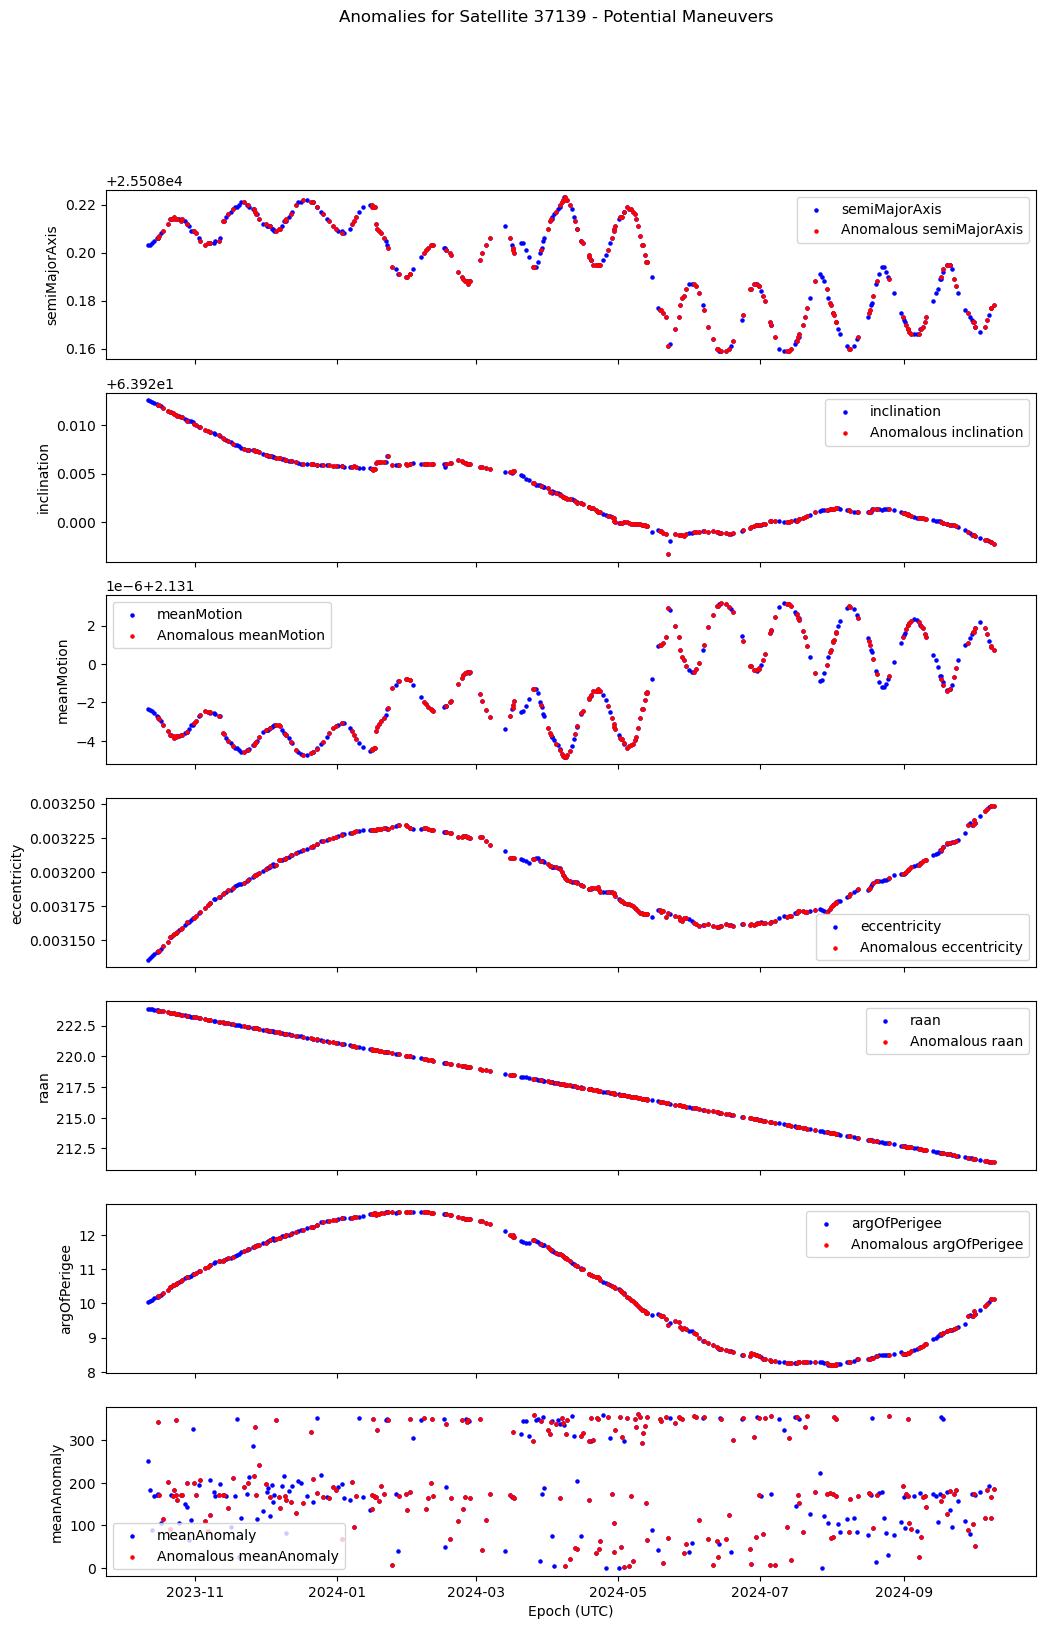

Processing satellite 37372


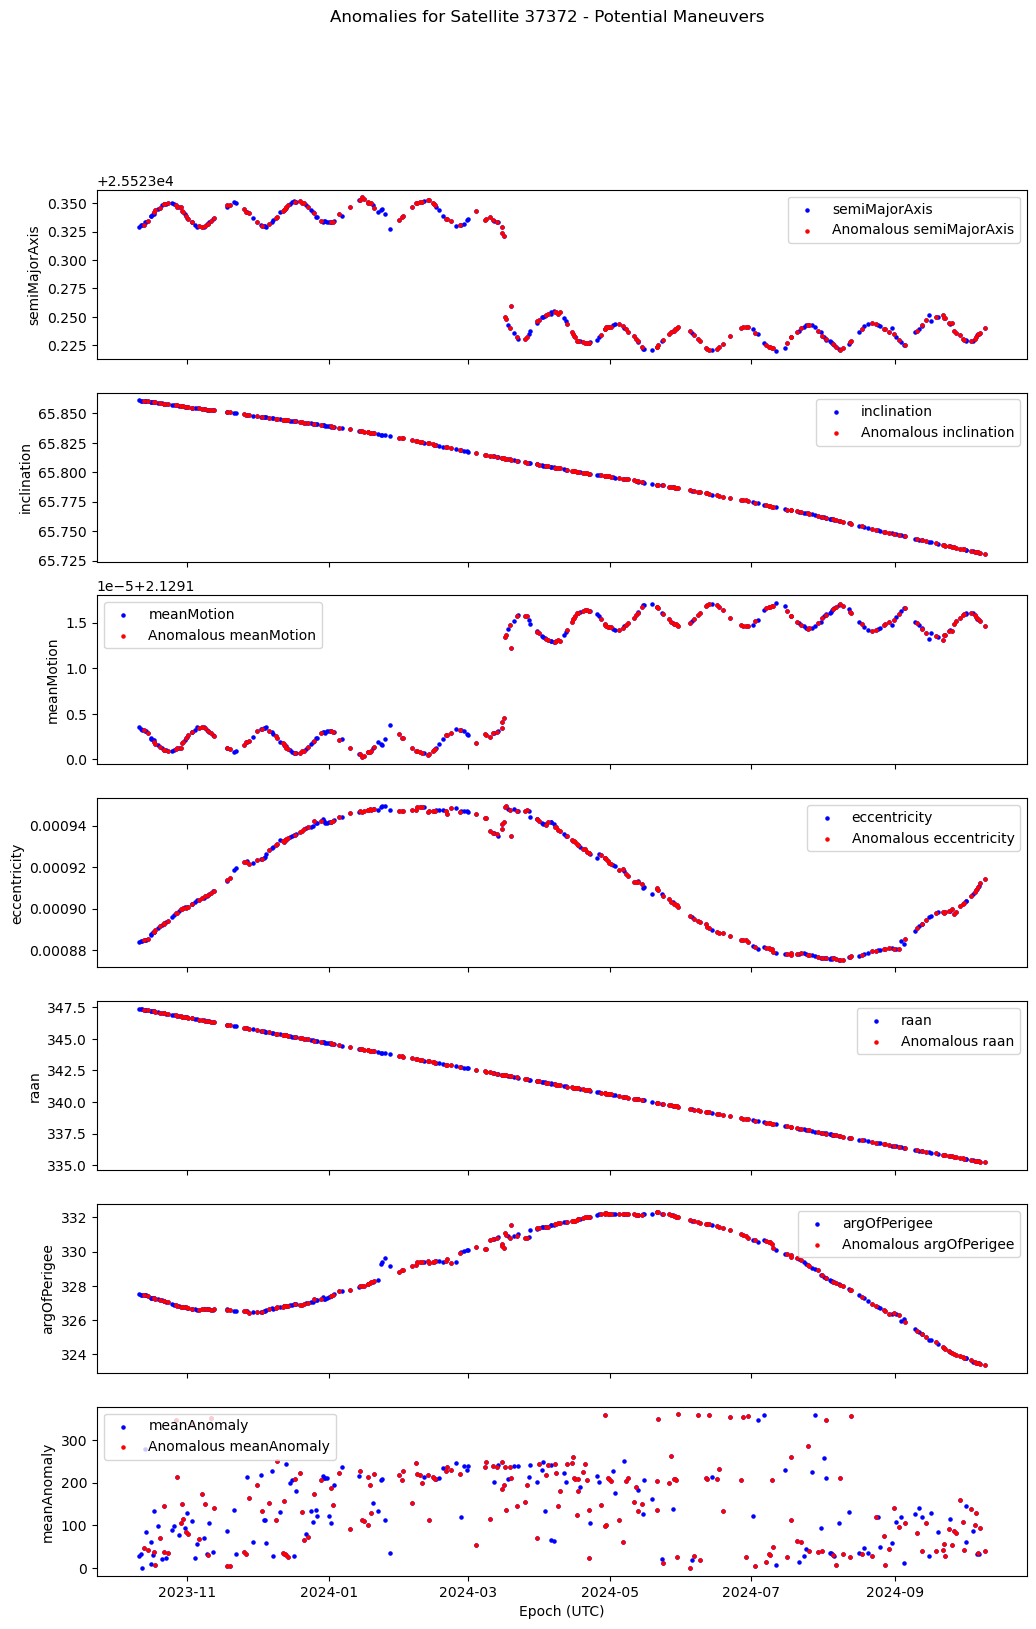

Processing satellite 37867


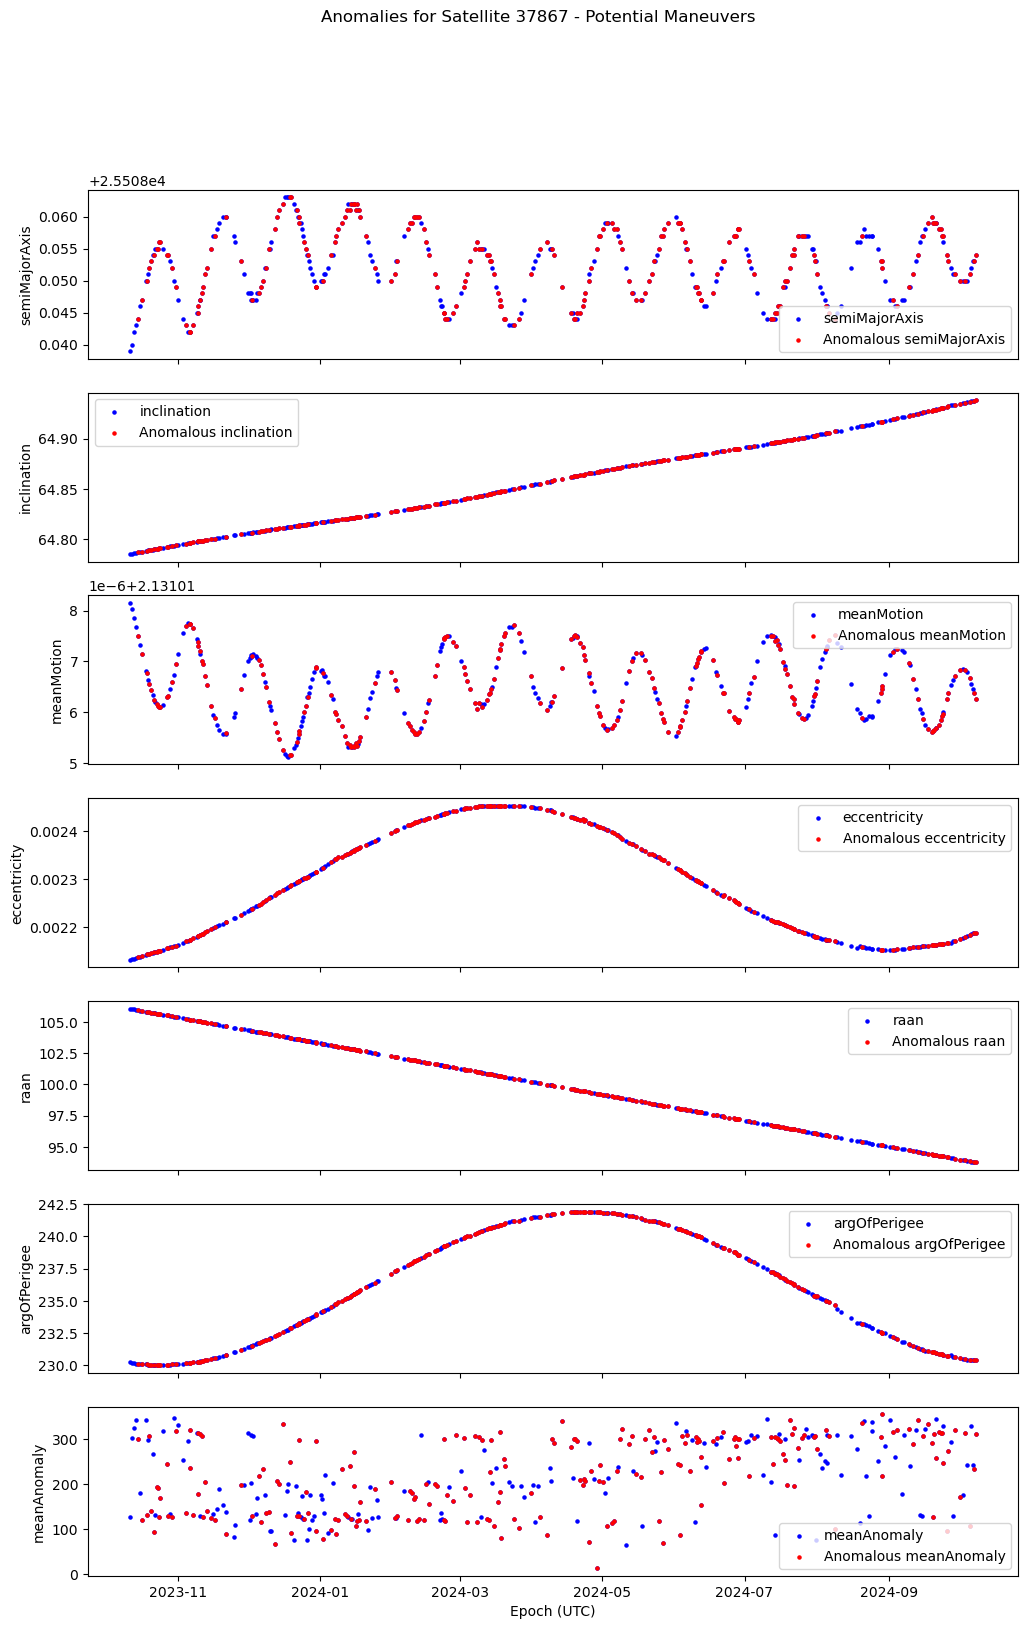

Processing satellite 37868


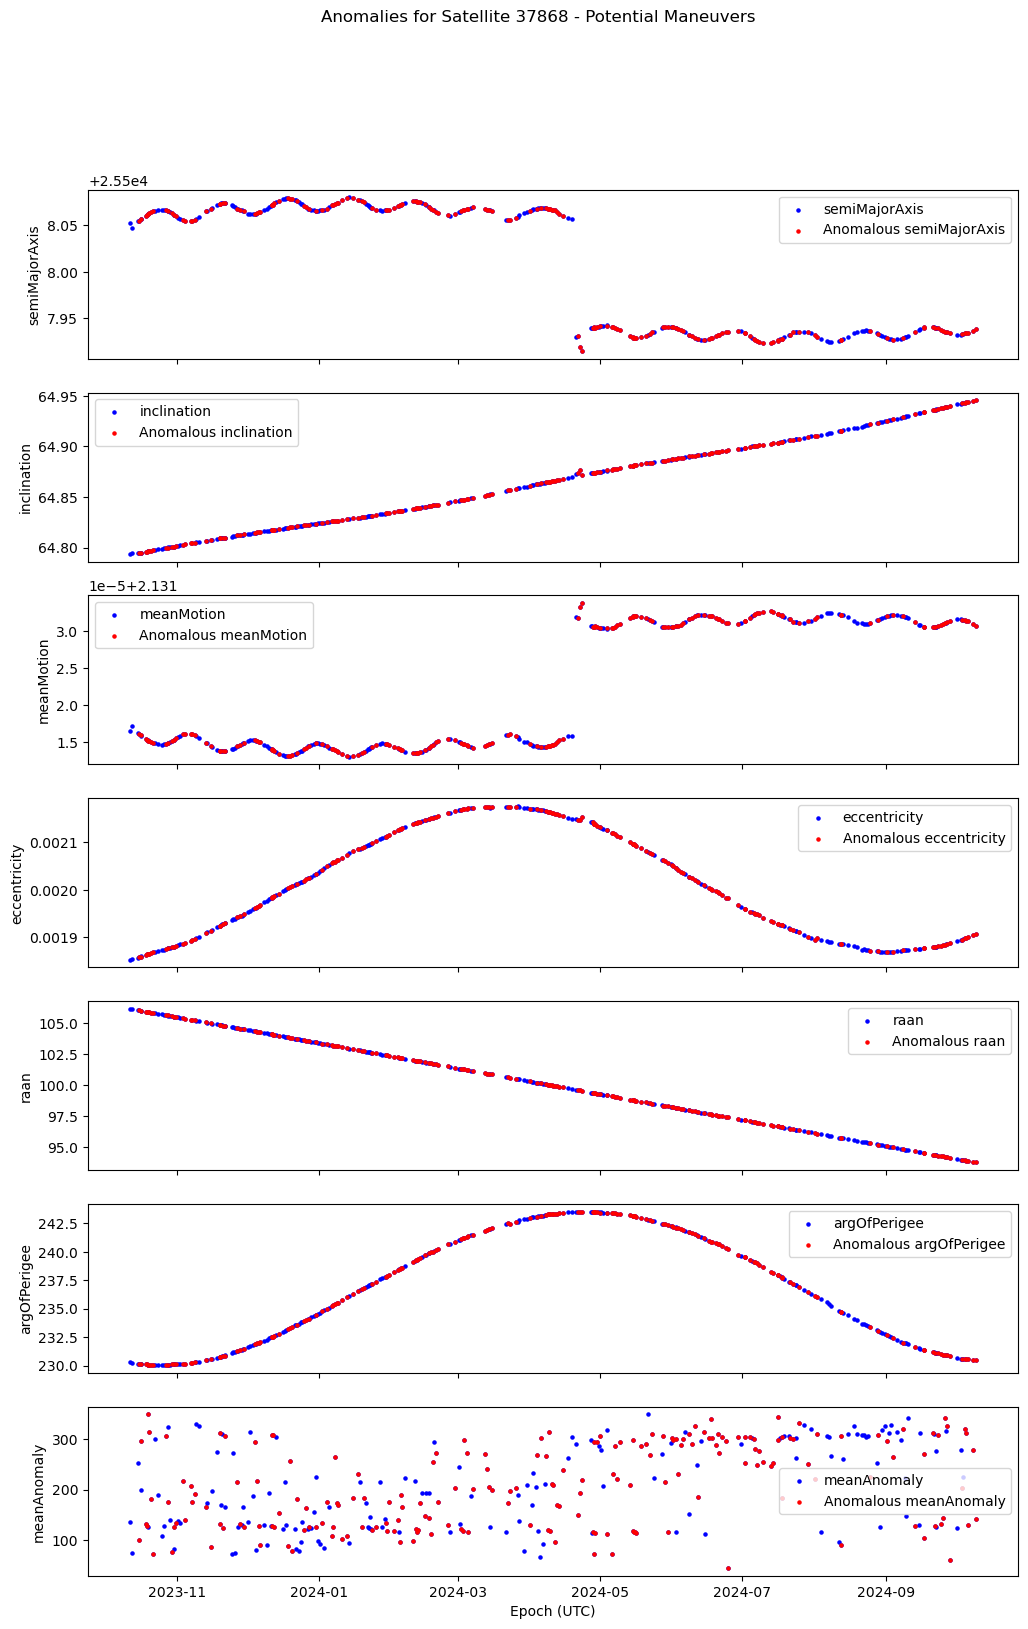

Processing satellite 37869


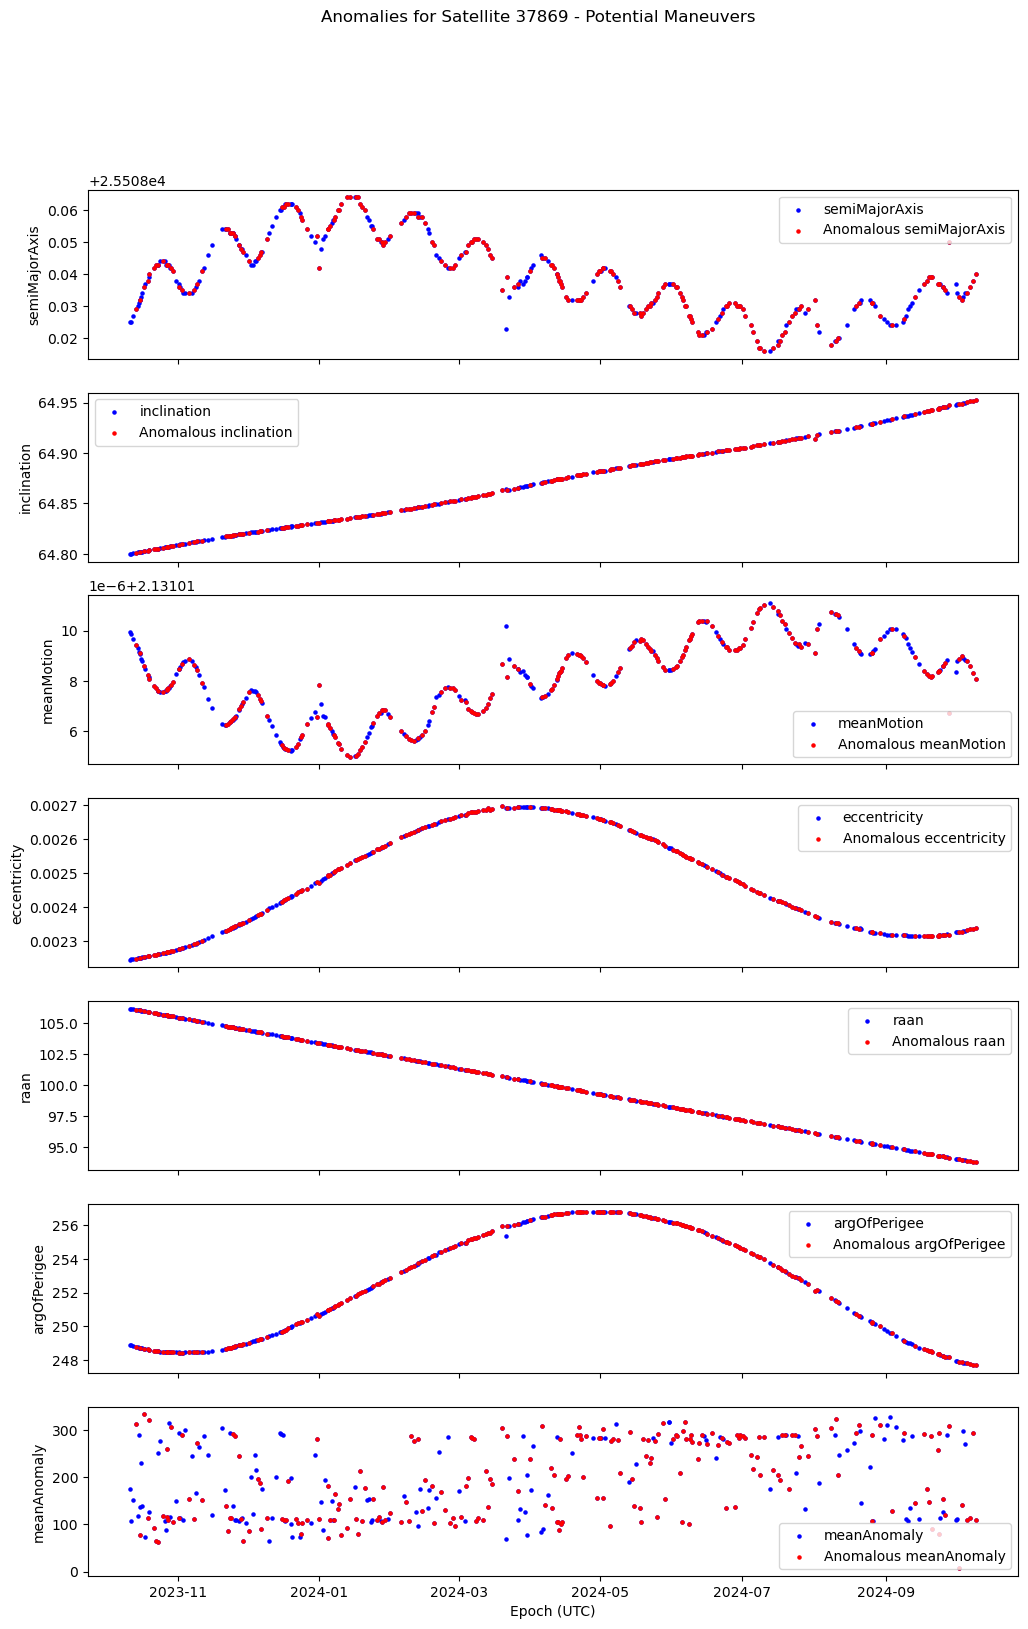

Processing satellite 39155


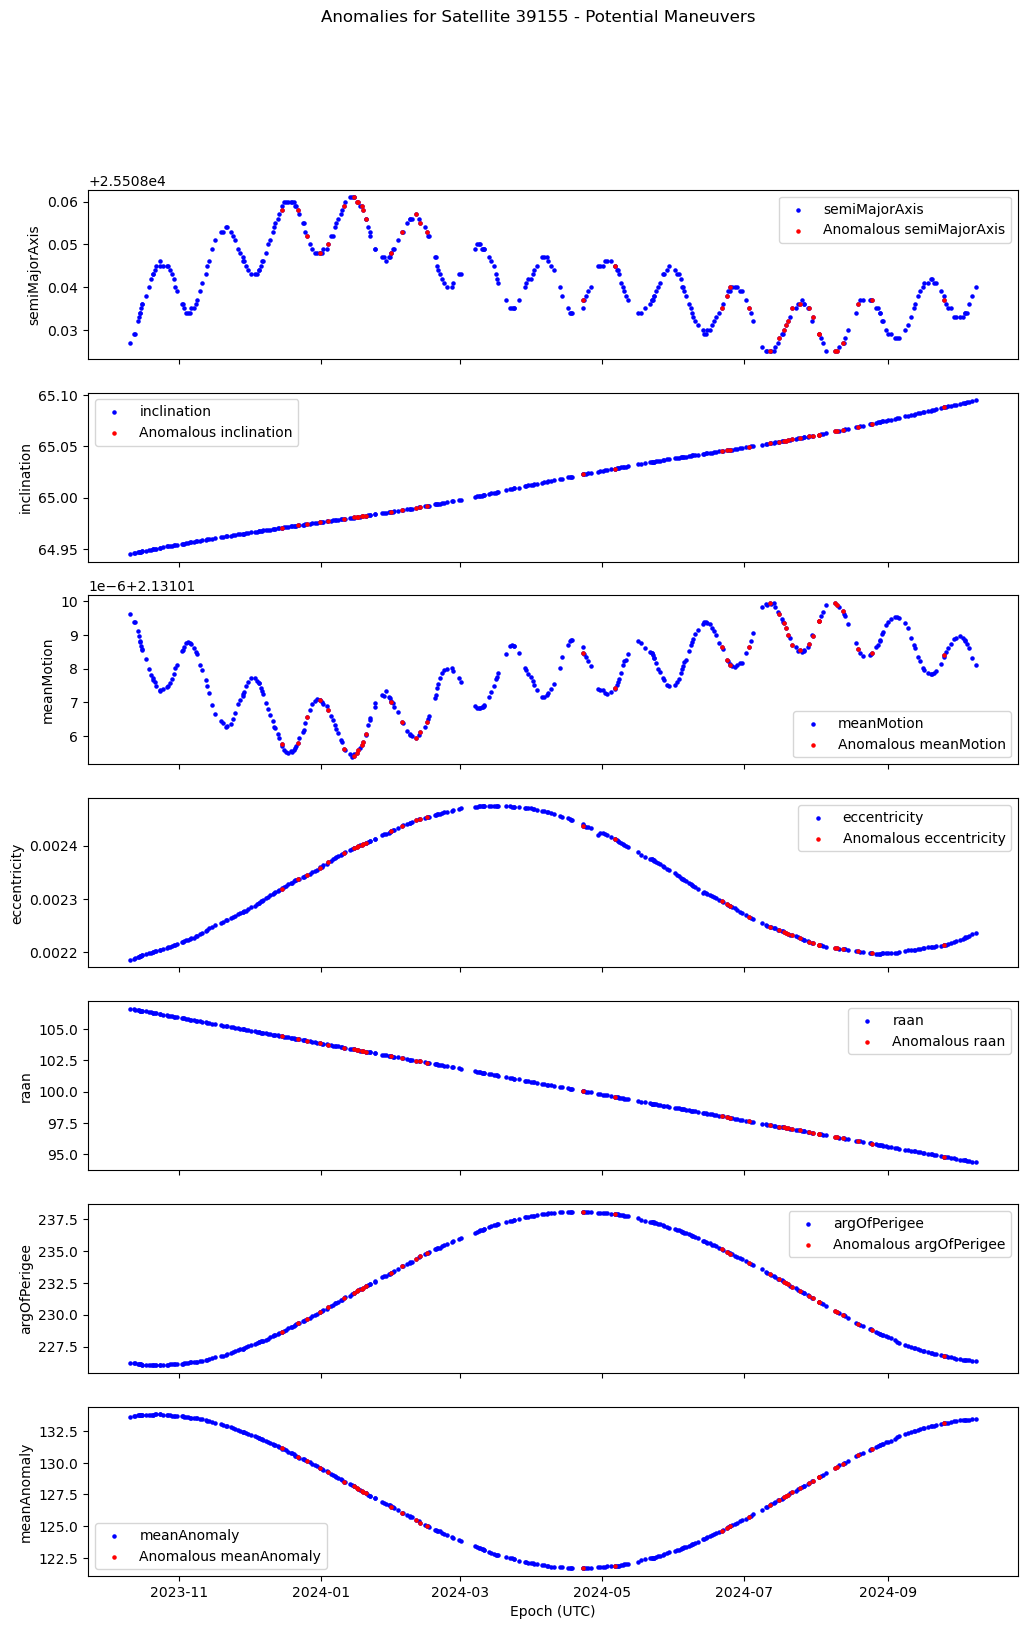

Processing satellite 40001


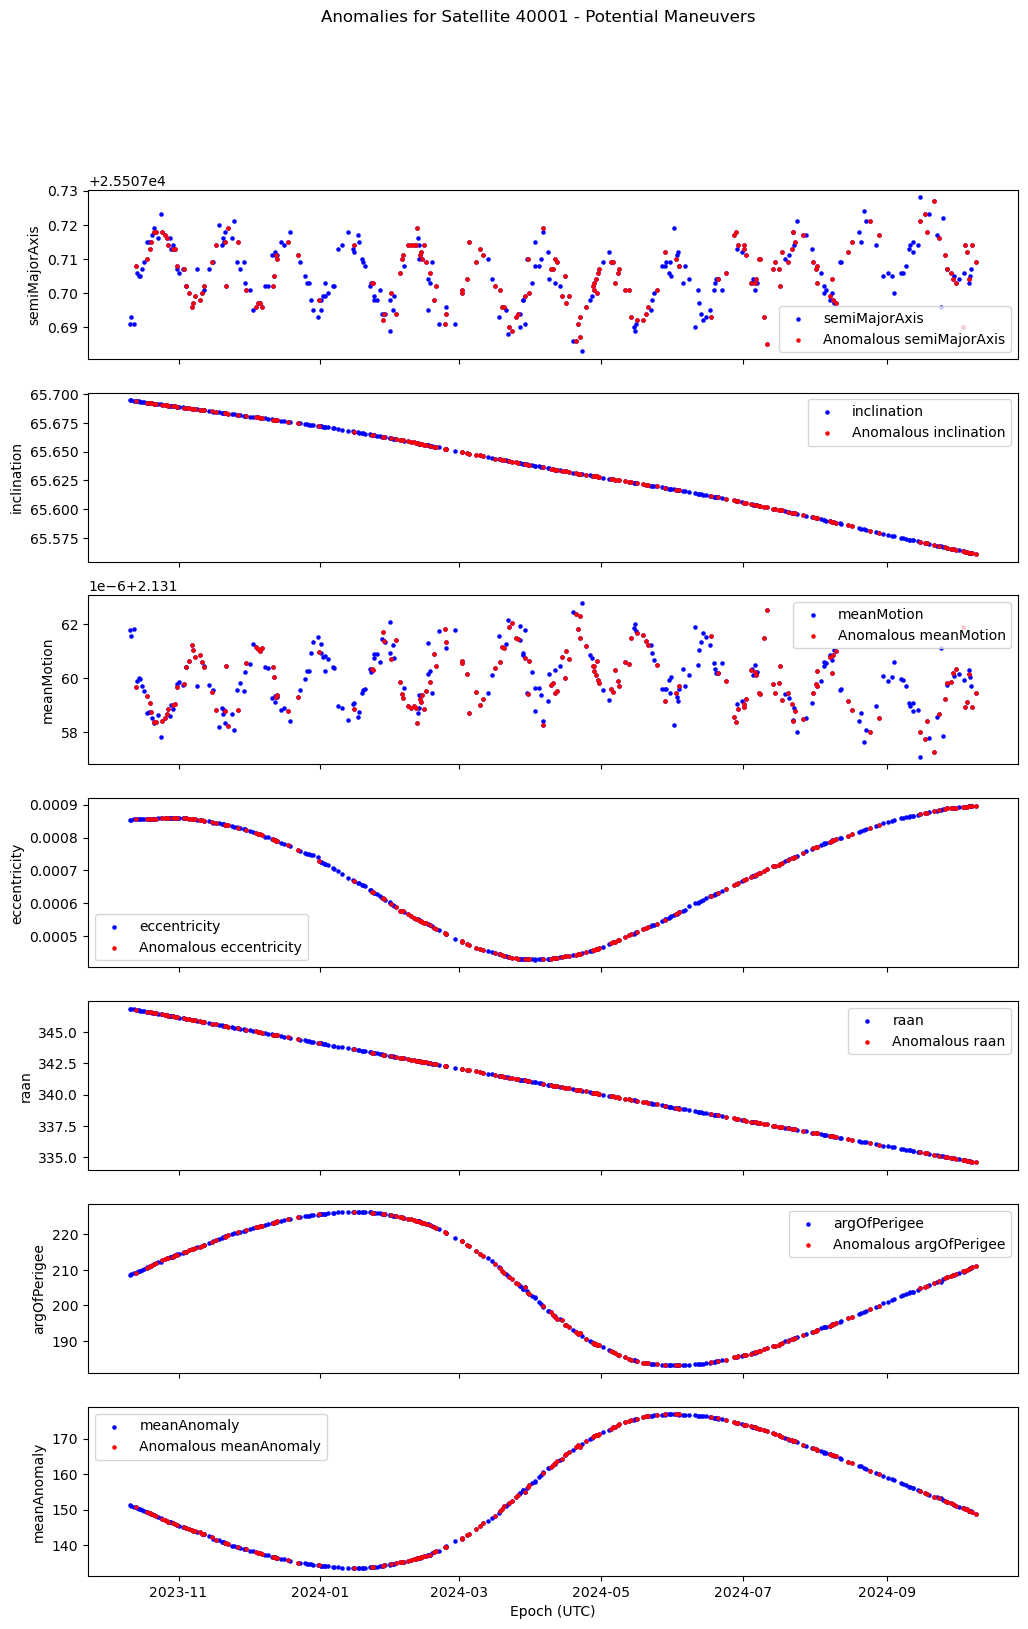

Processing satellite 40315


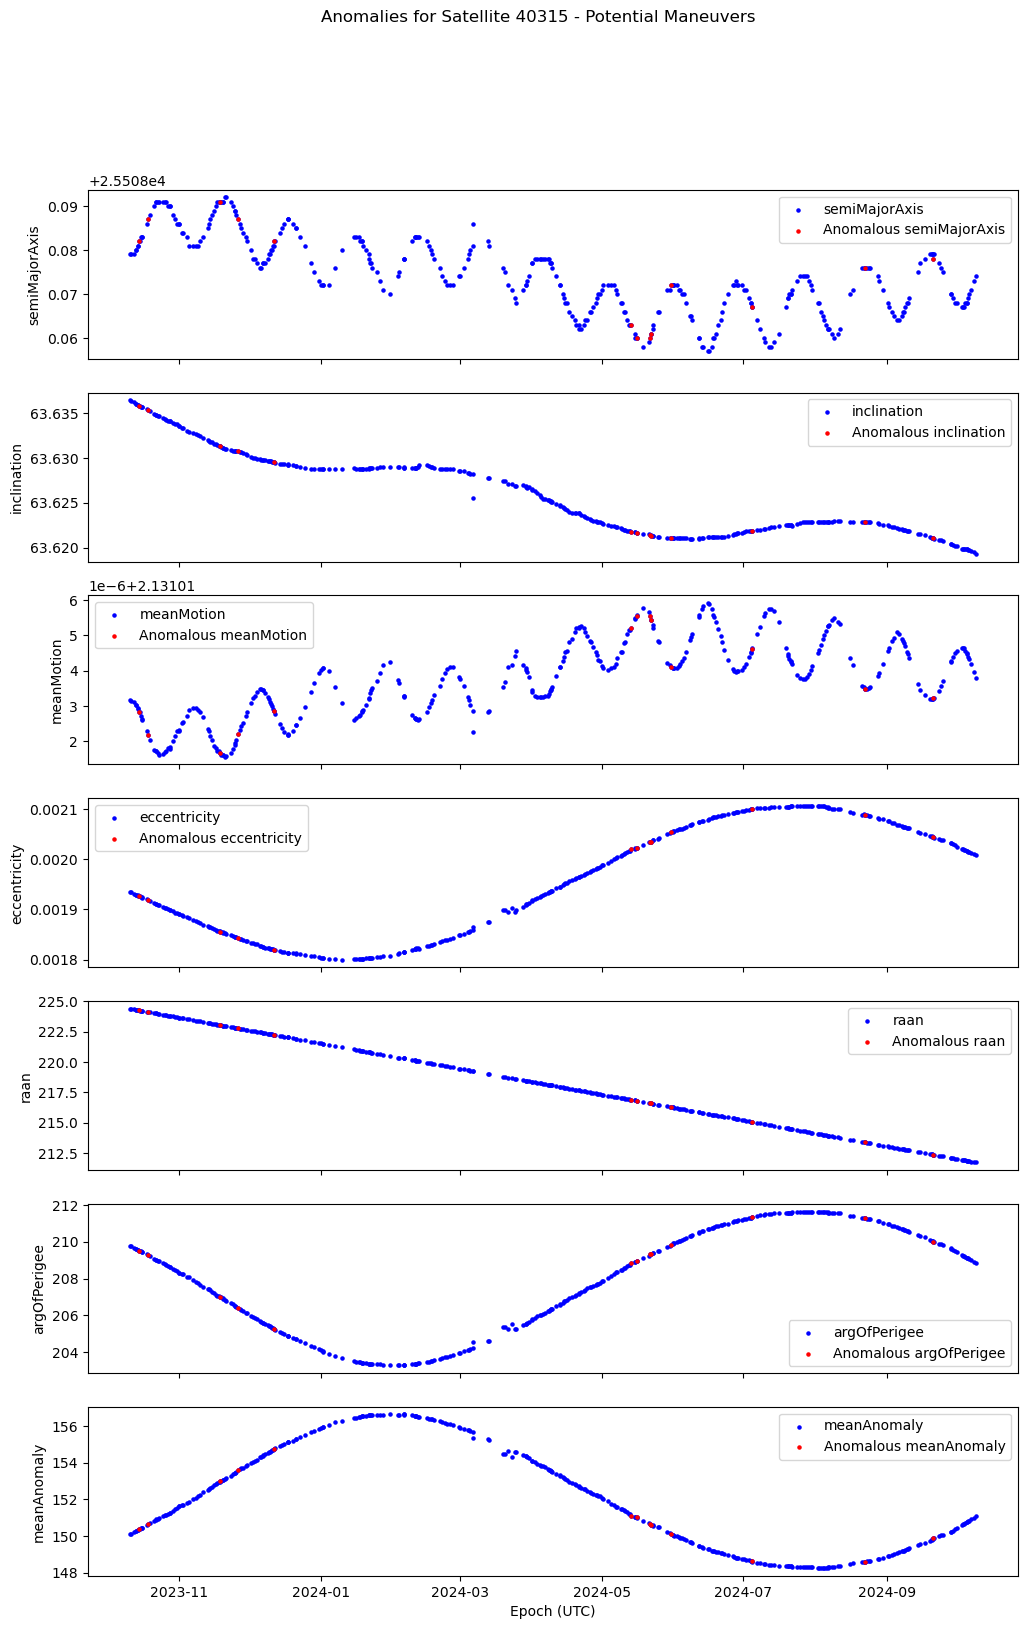

Processing satellite 41330


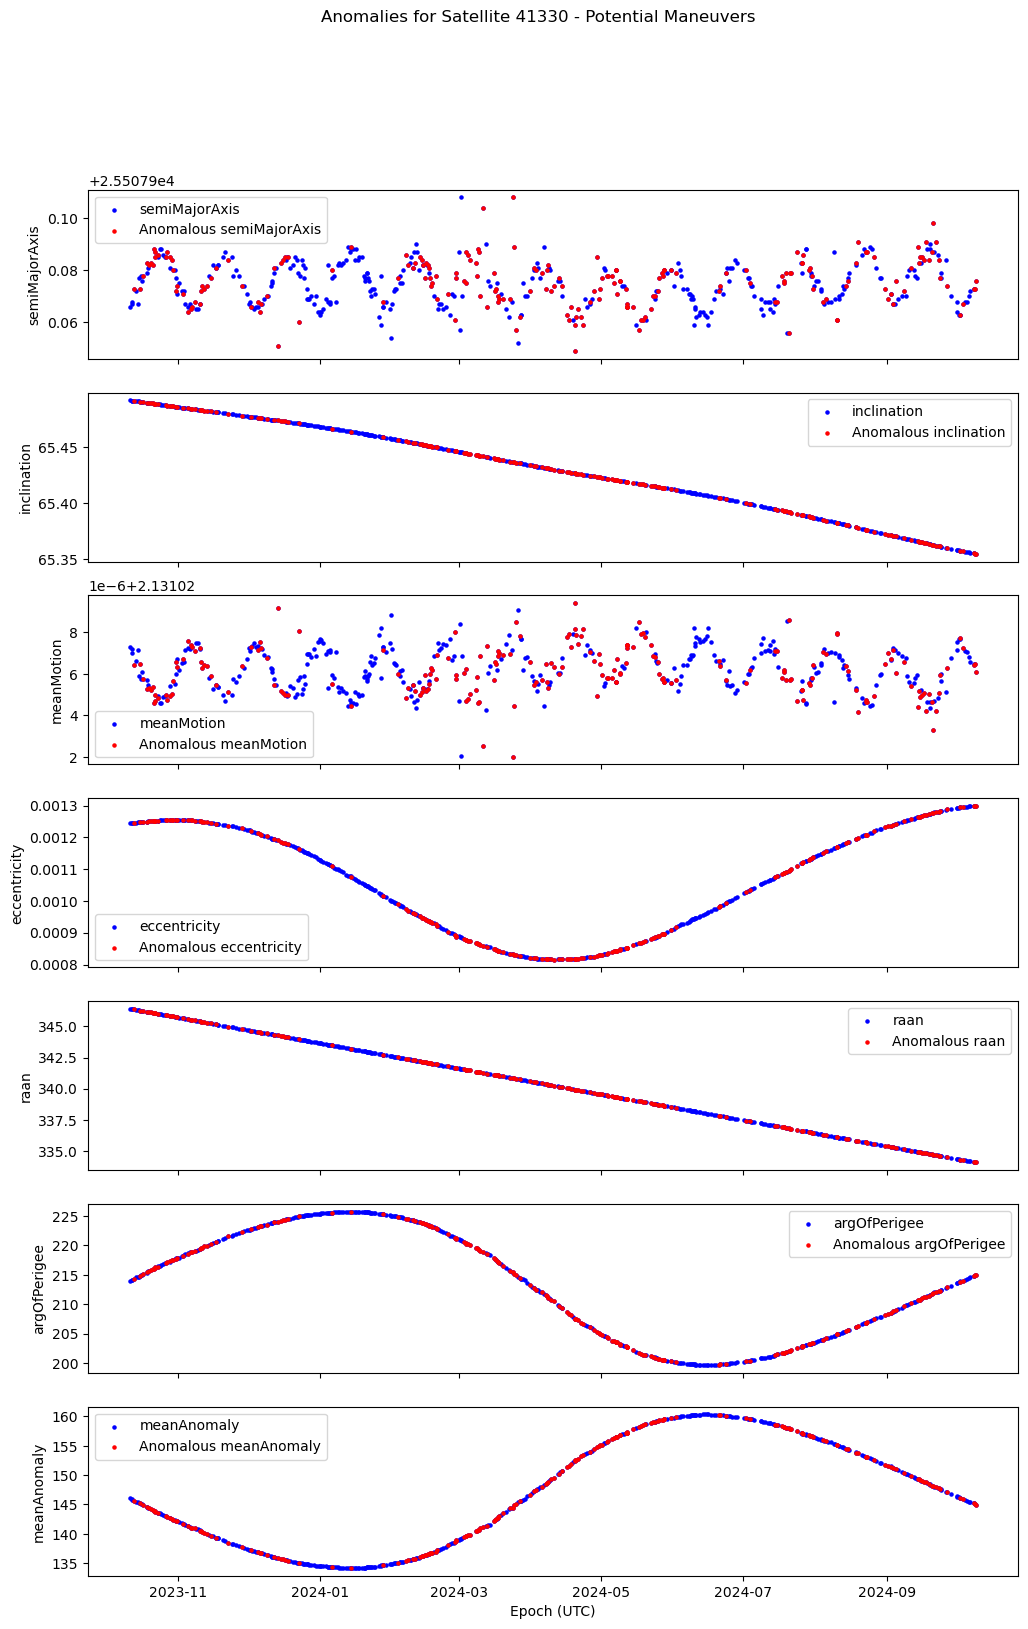

Processing satellite 41554


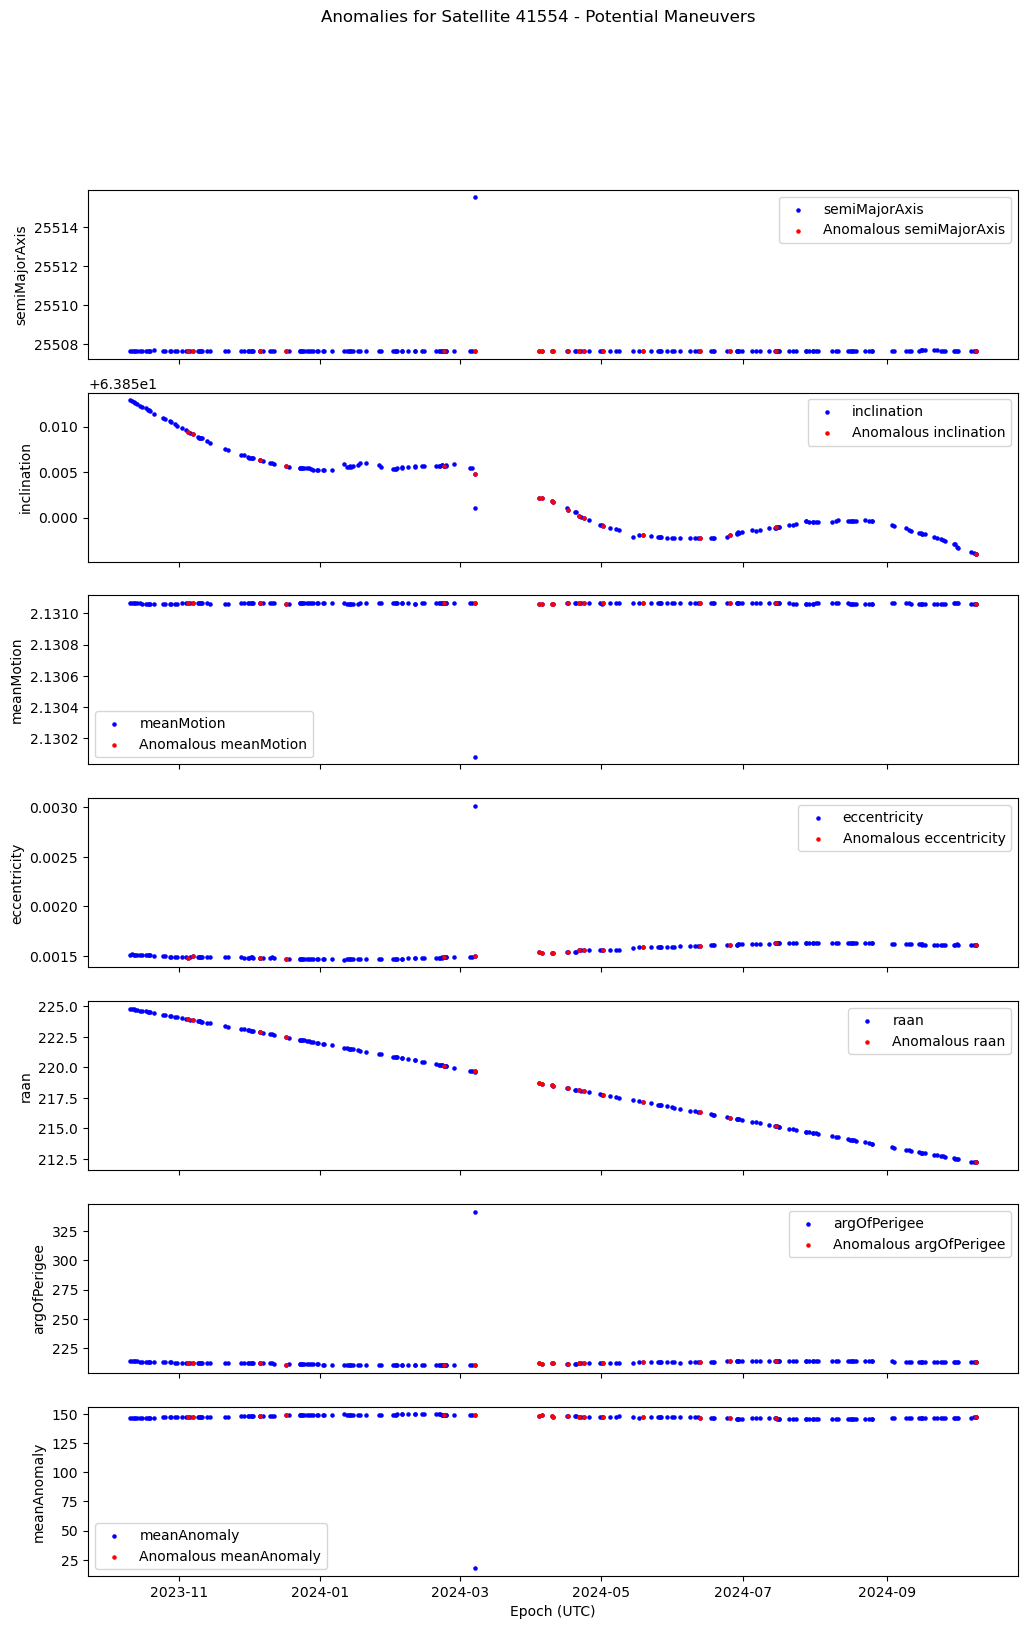

Processing satellite 42939


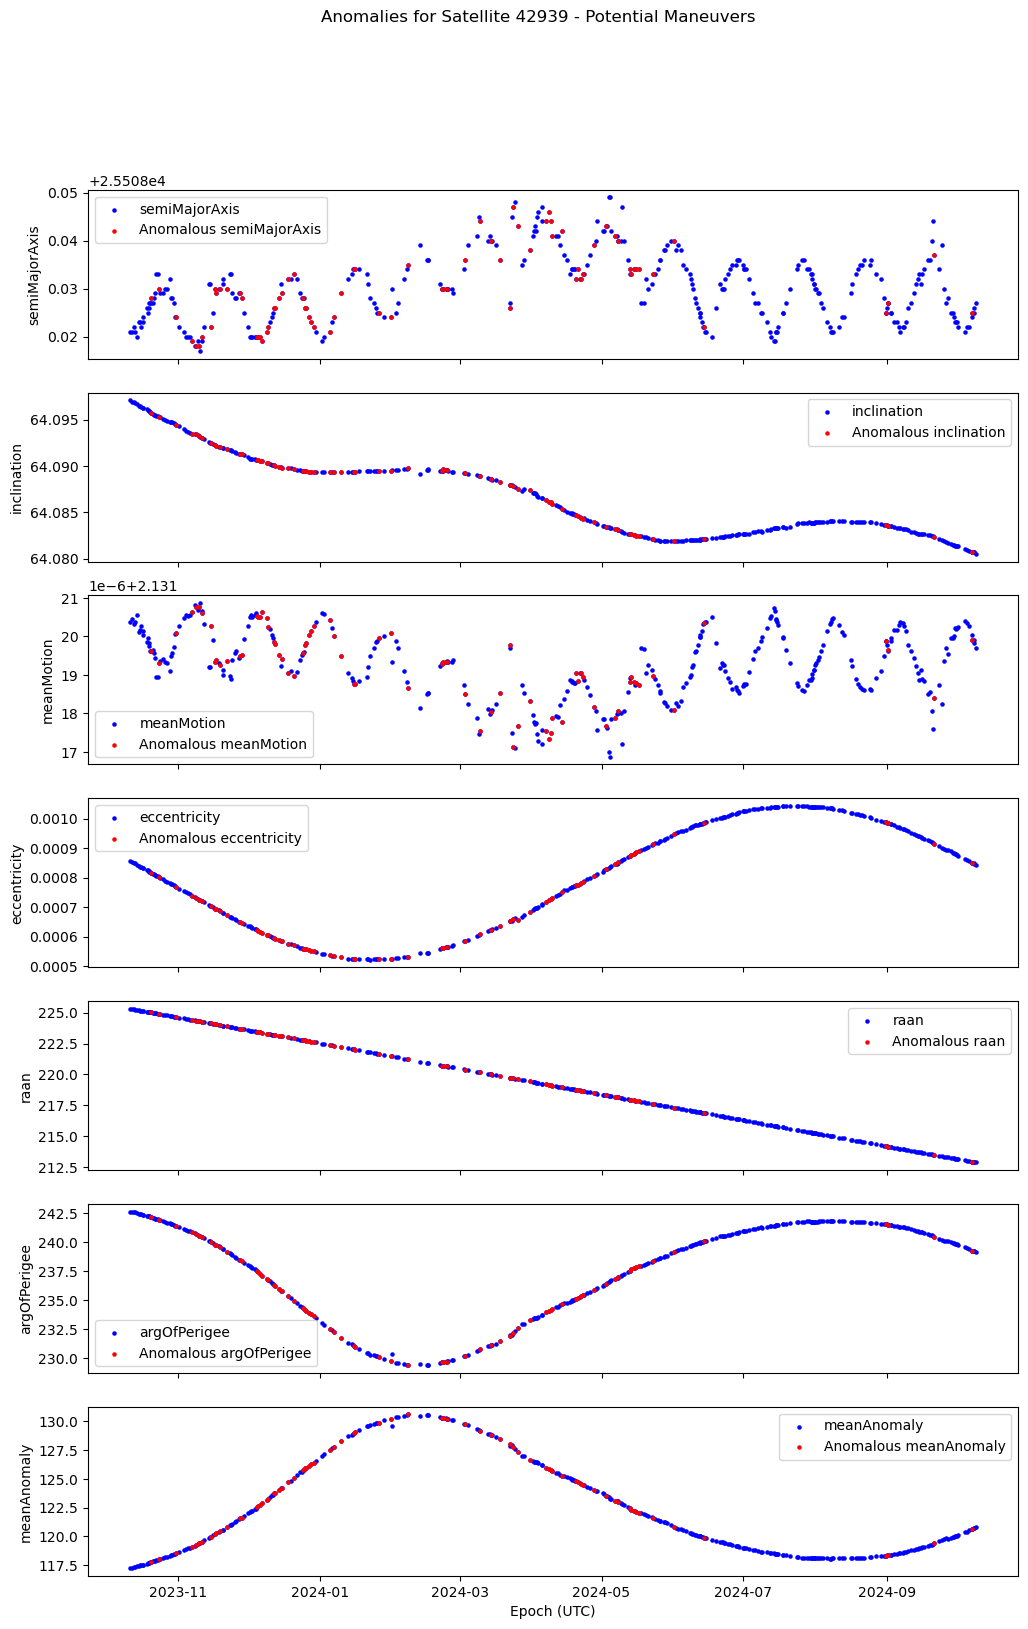

Processing satellite 43508


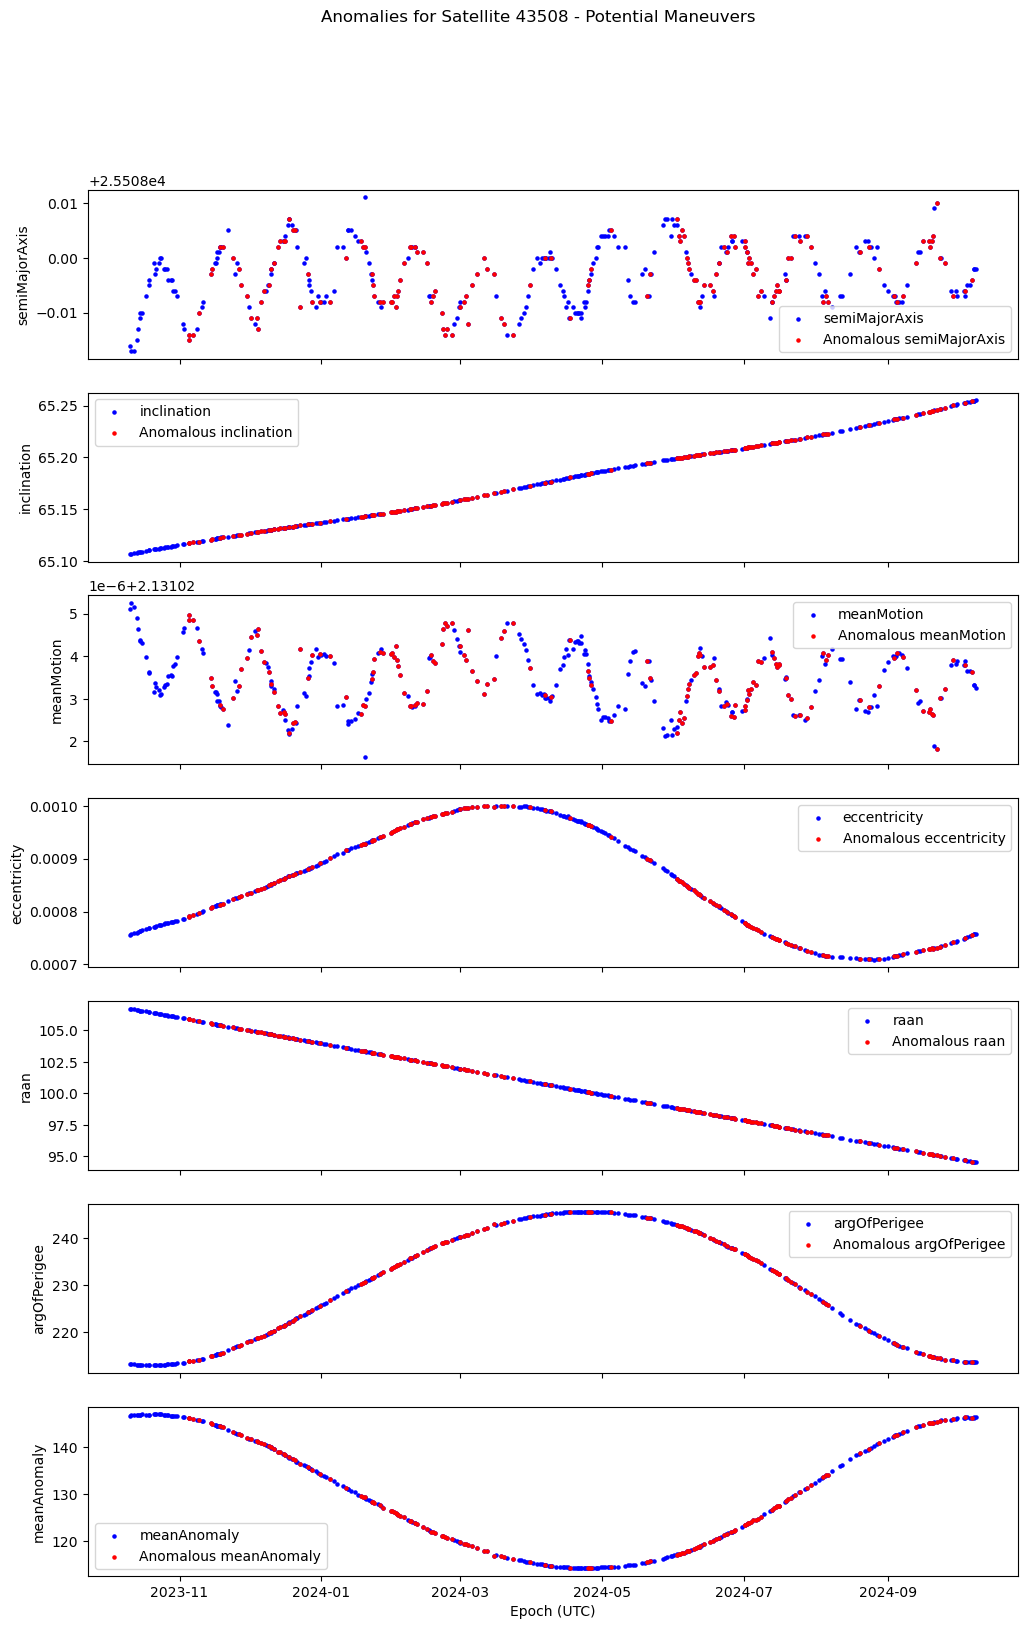

Processing satellite 43687


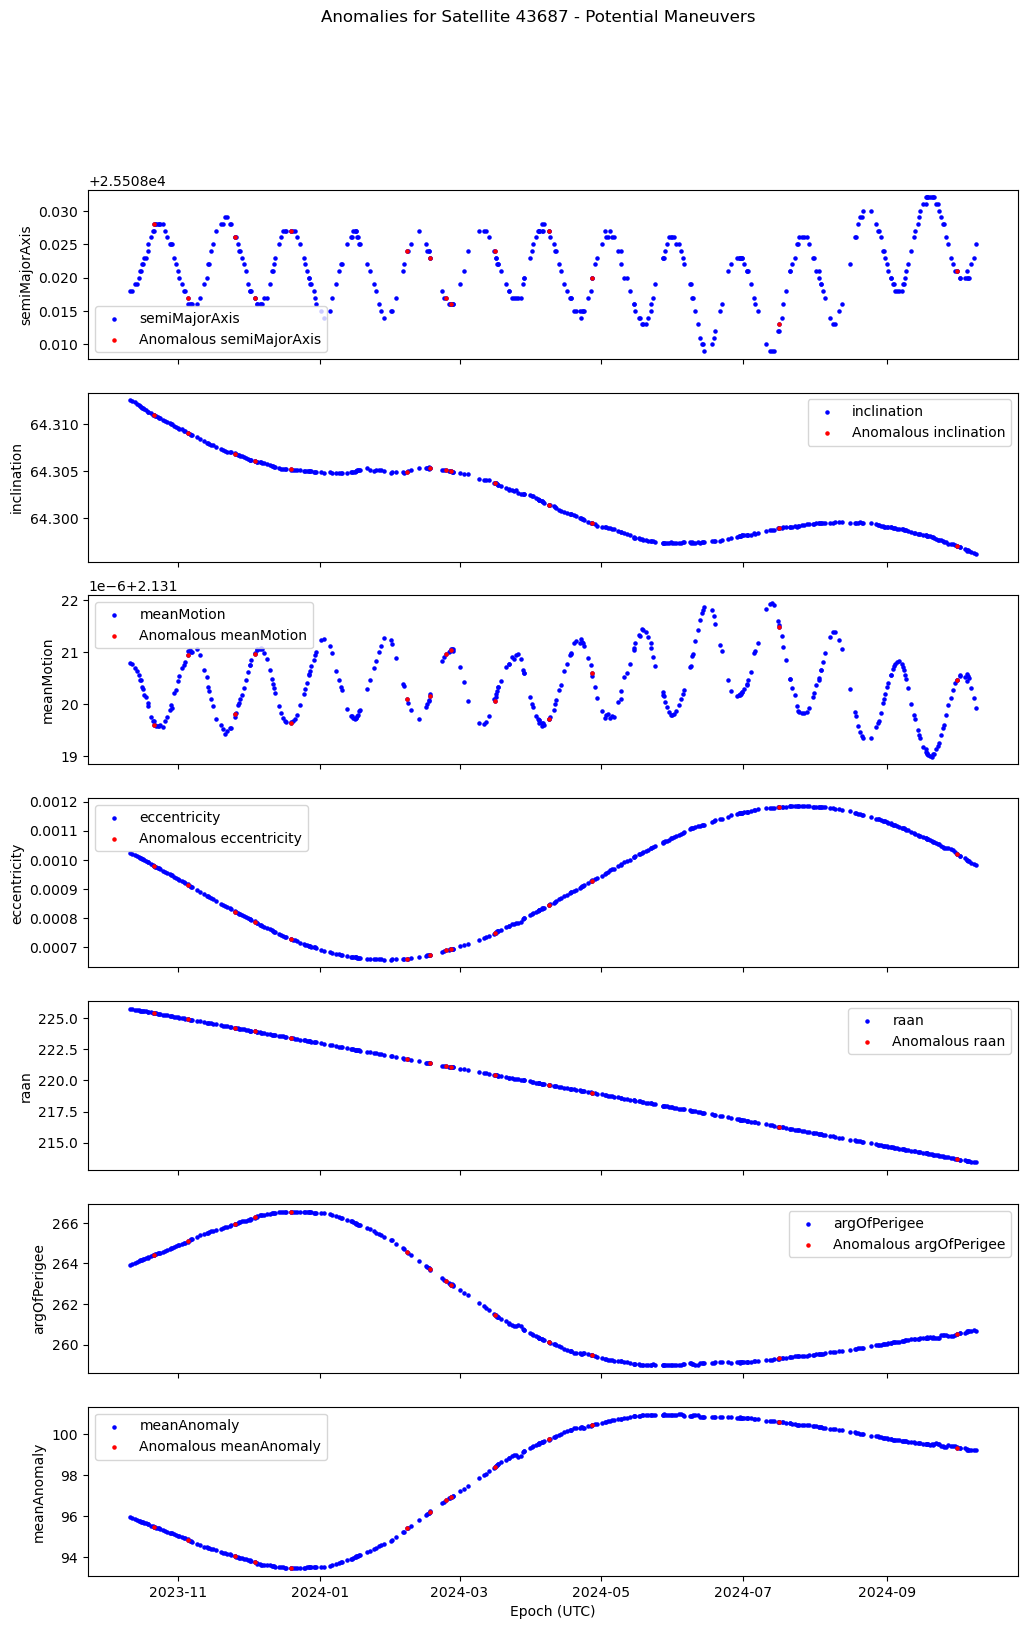

Processing satellite 44299


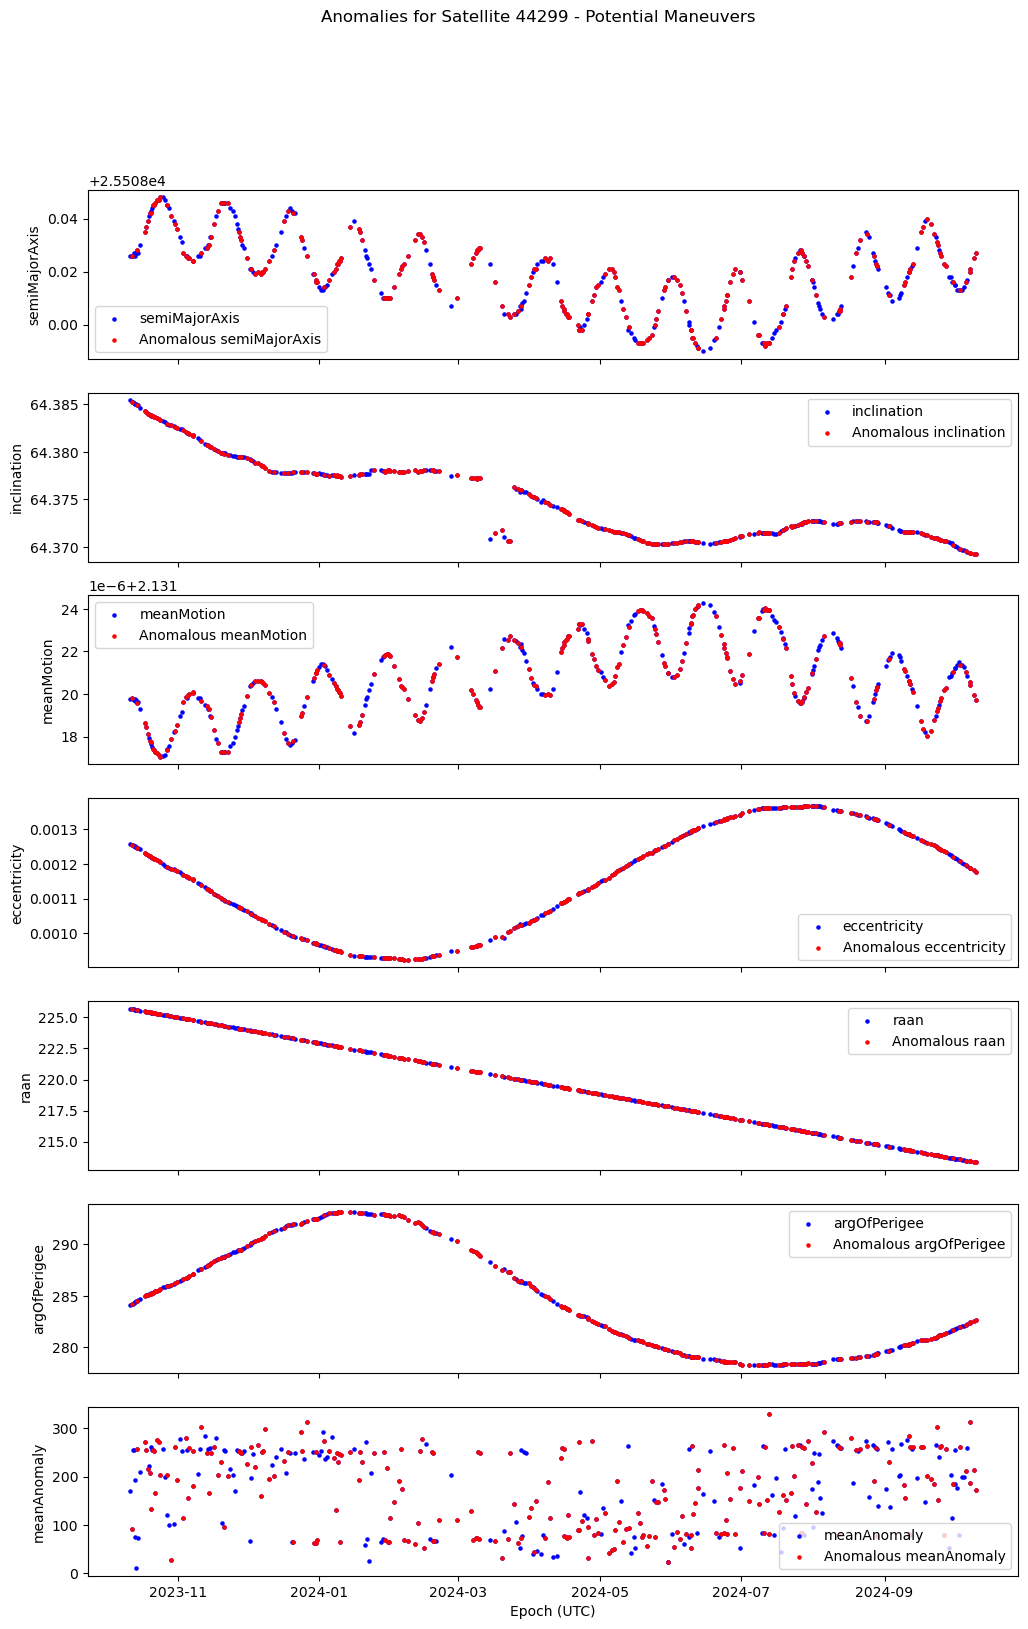

Processing satellite 44850


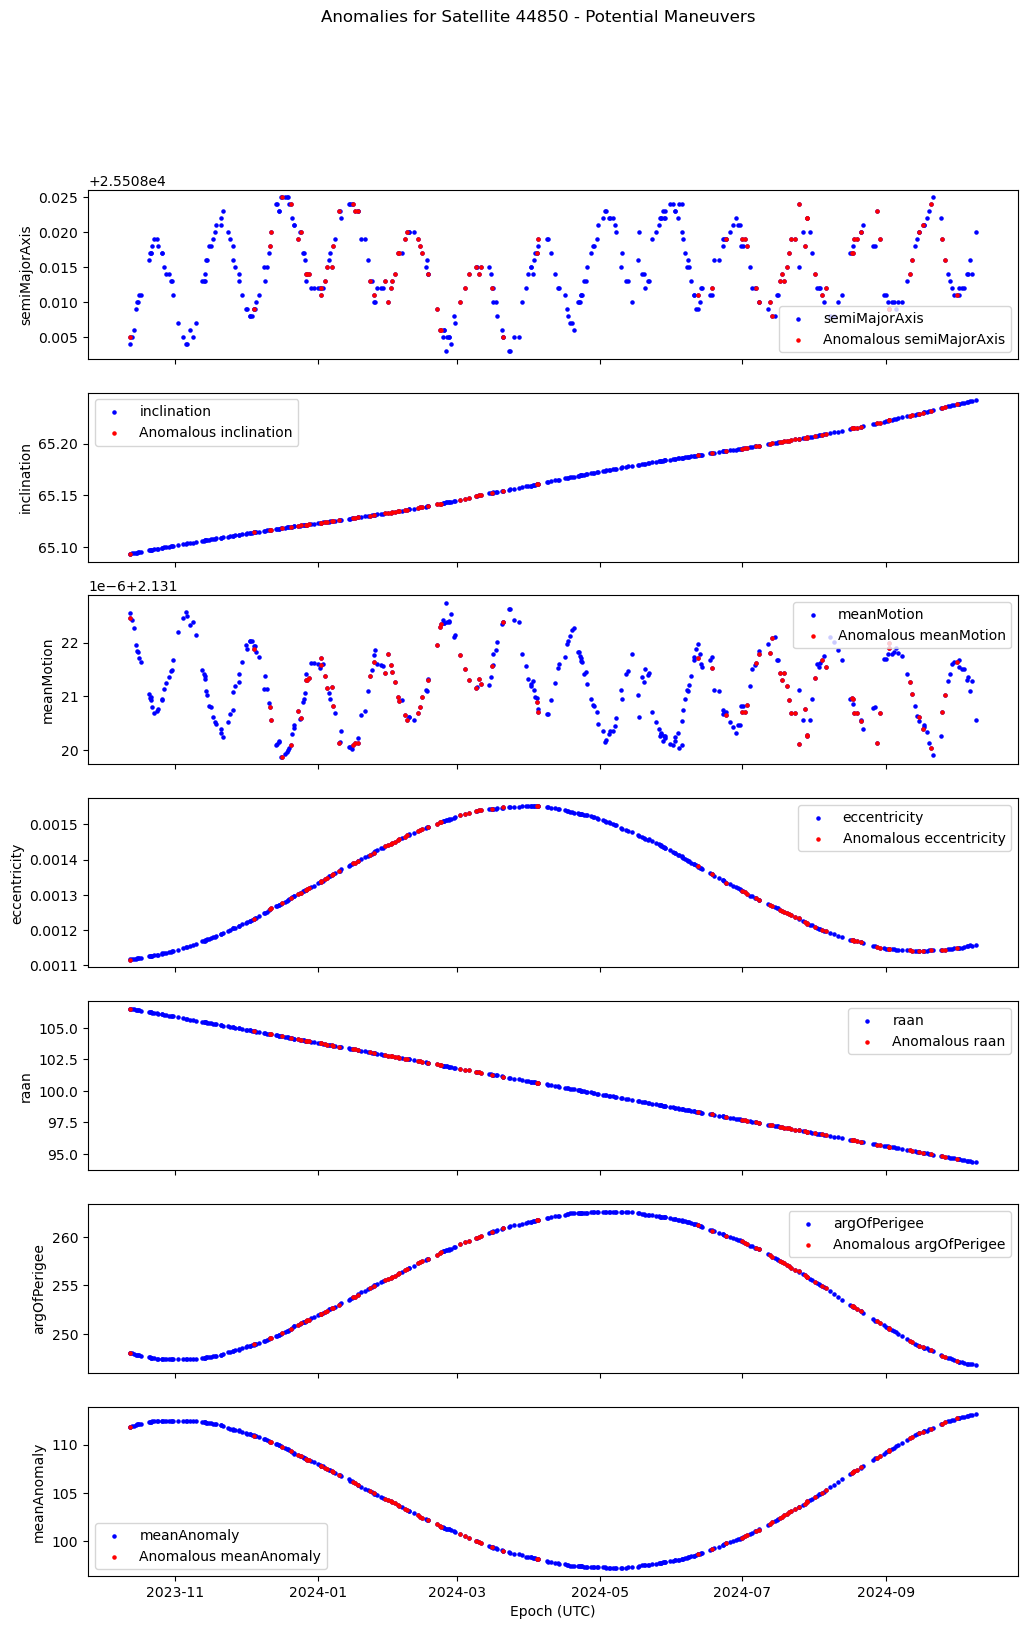

Processing satellite 45358


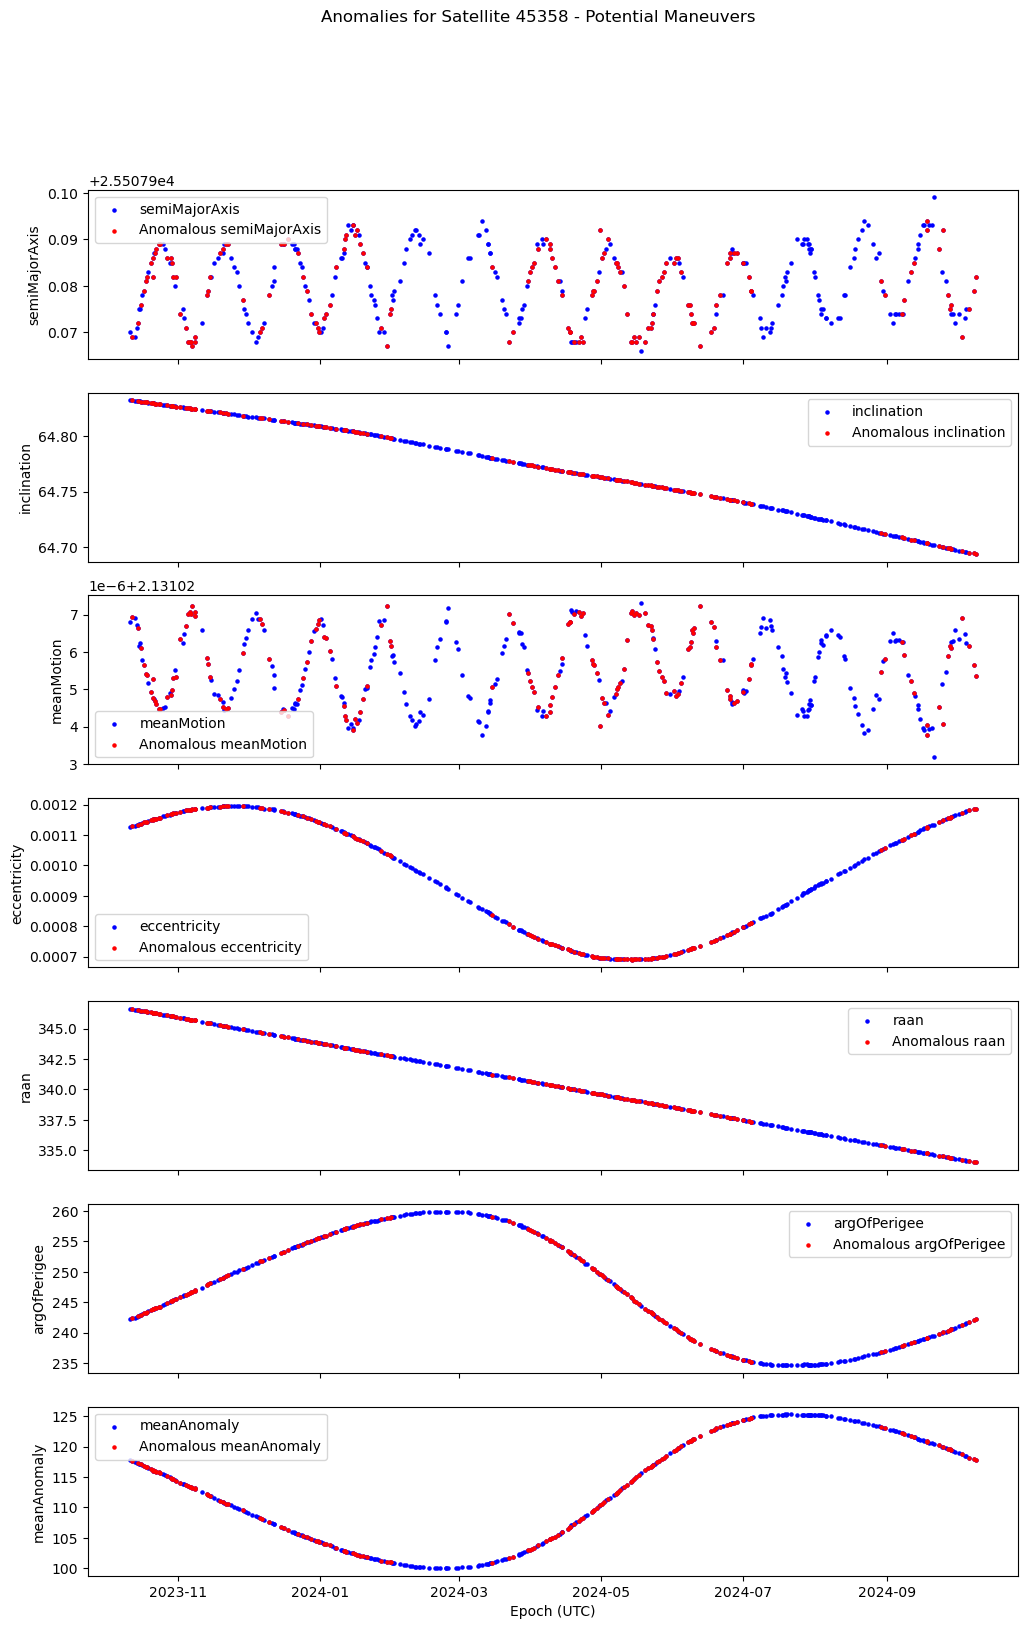

Processing satellite 46805


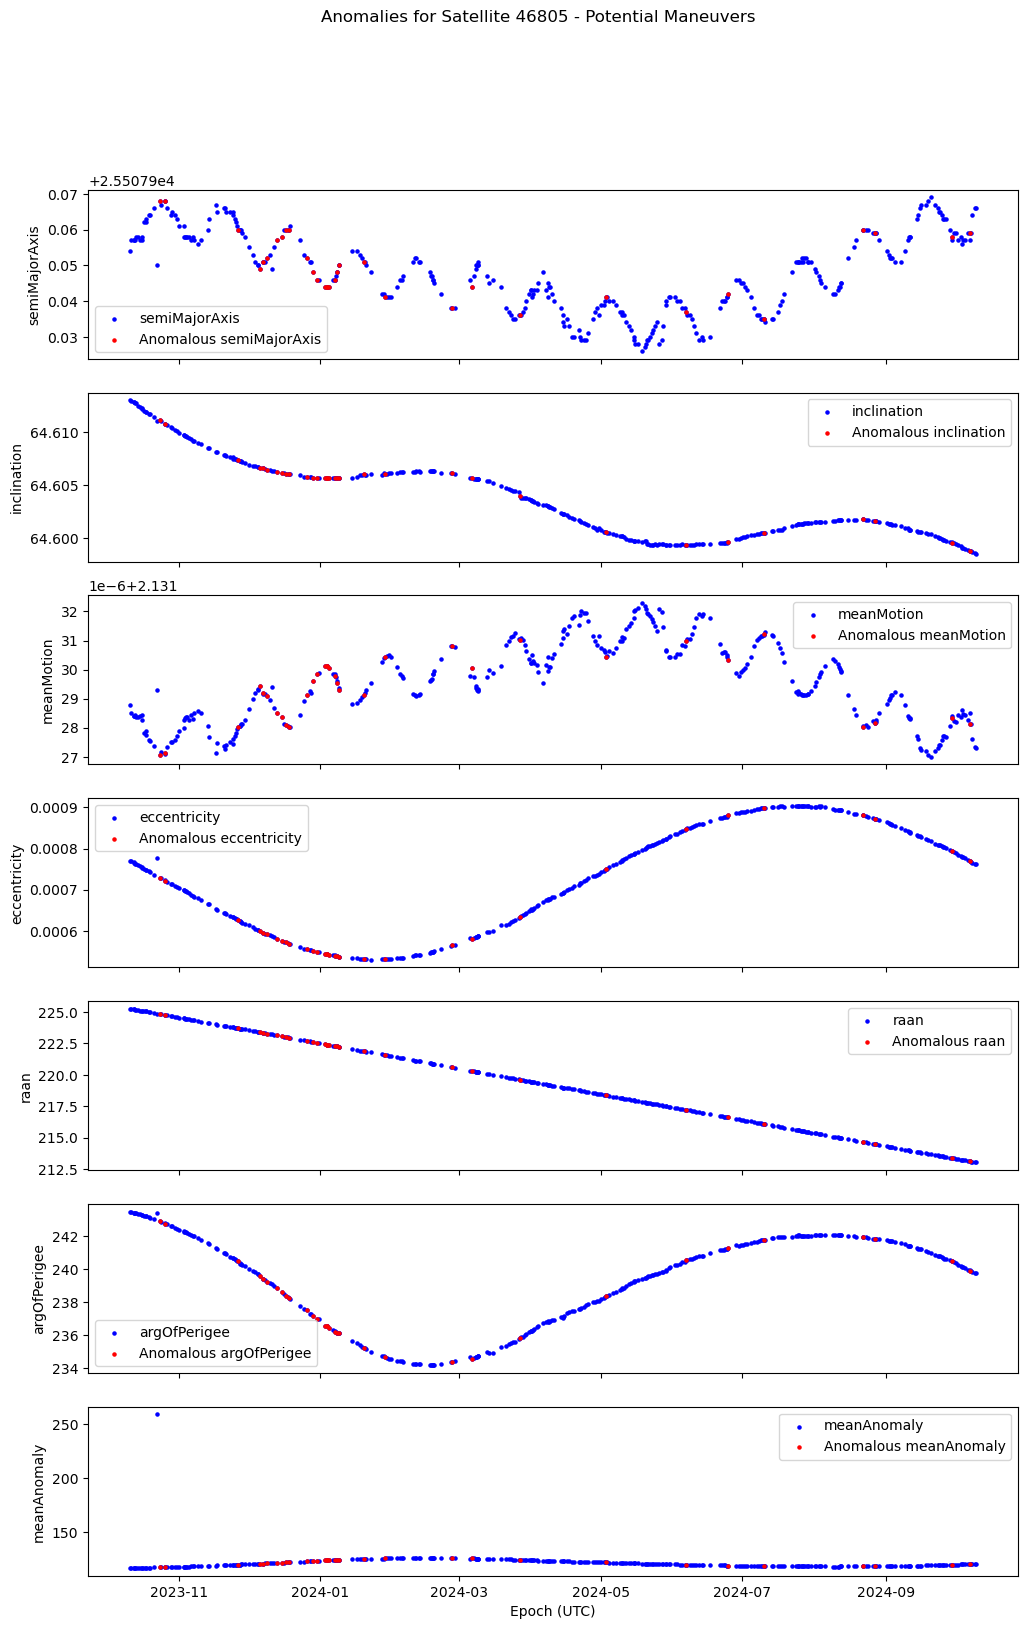

Processing satellite 52984


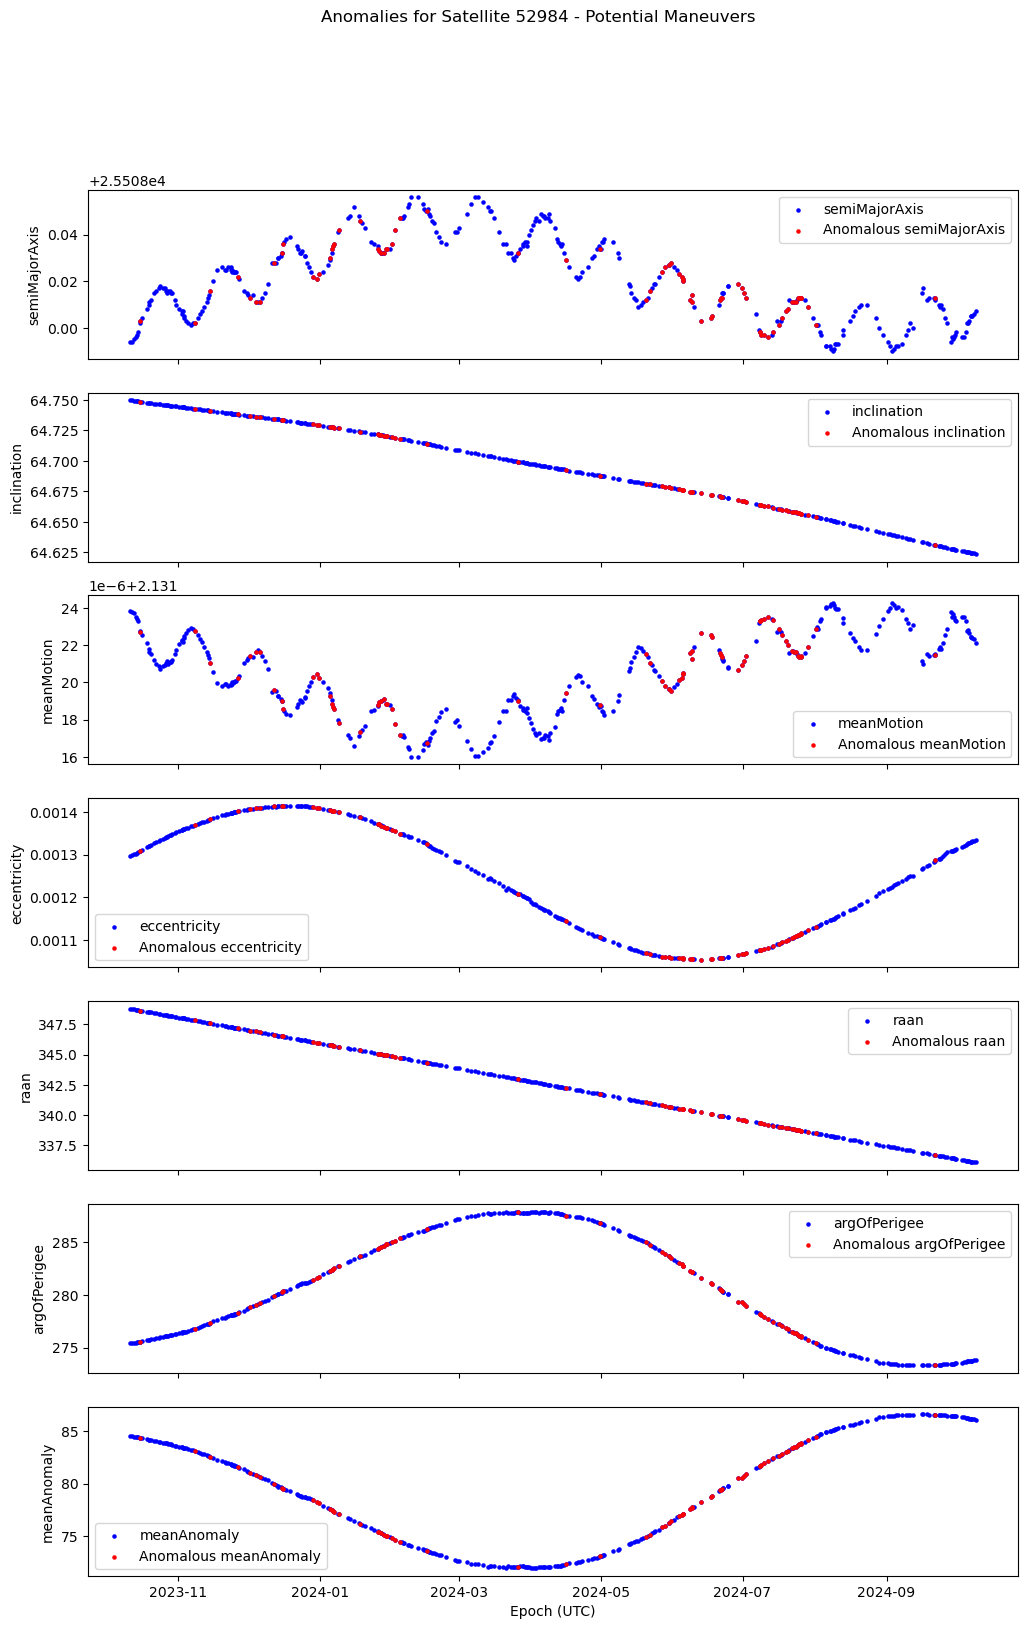

Processing satellite 54031


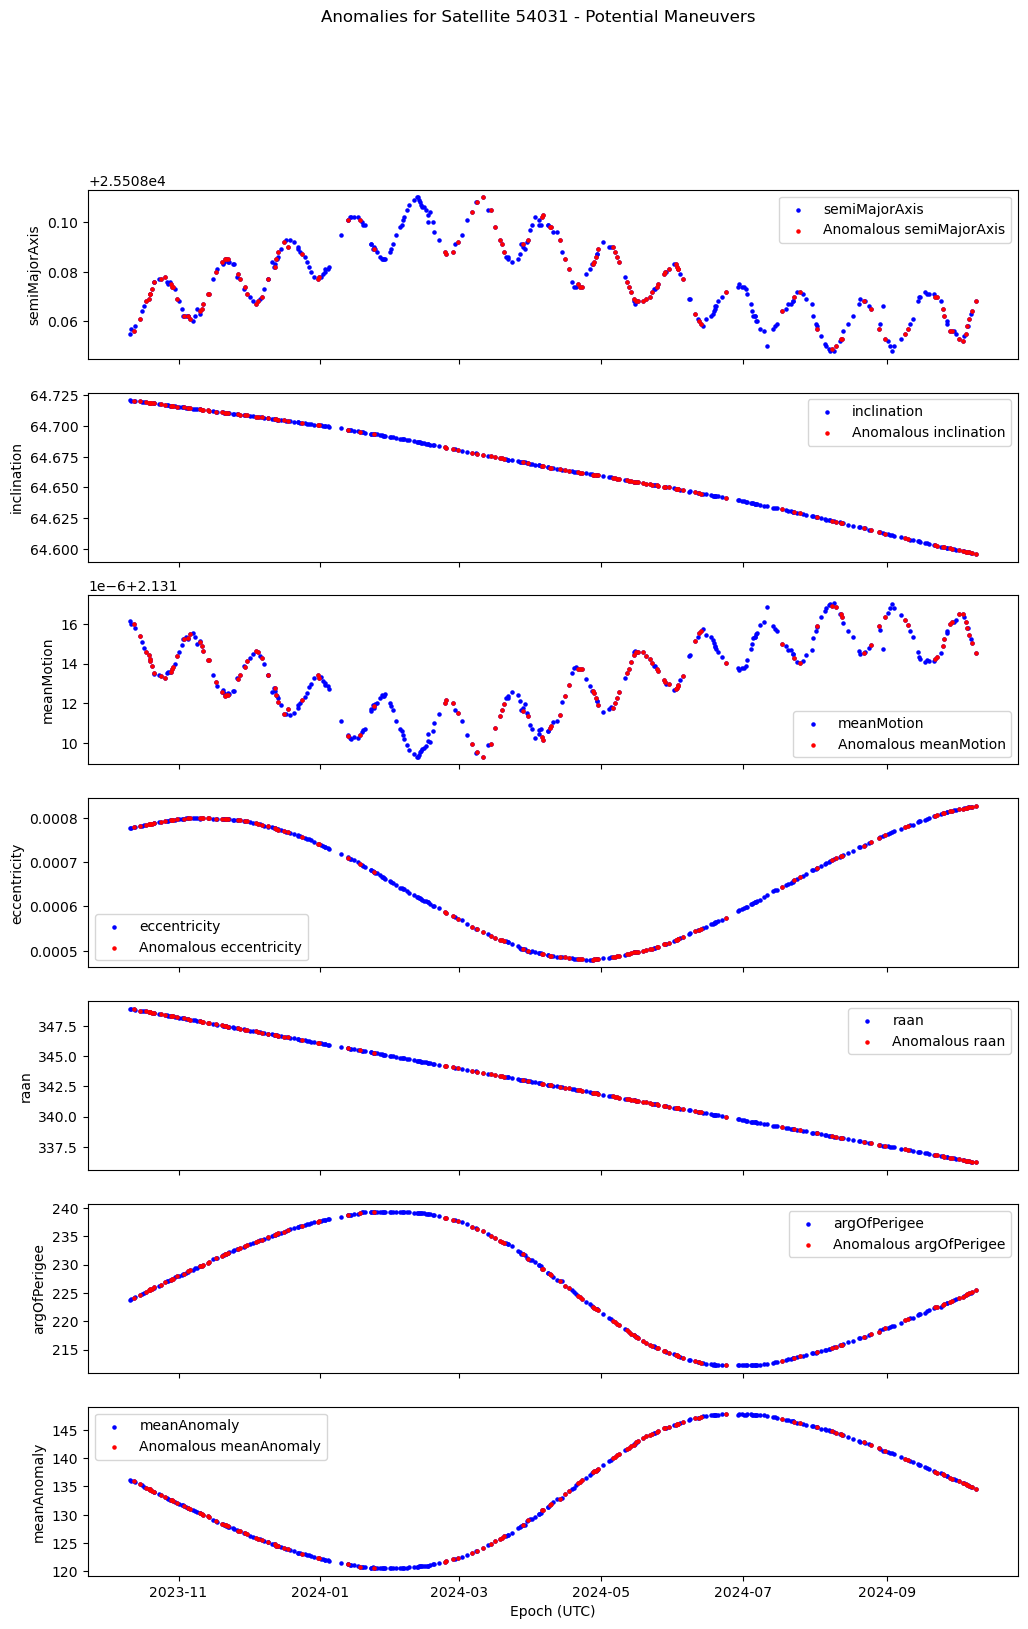

Total anomalies detected: 4659


In [18]:
def detect_and_visualize_anomalies_with_subplots(data, semi_major_axis_threshold=10, inclination_threshold=0.1,
                                                 mean_motion_threshold=0.05, eccentricity_threshold=0.001,
                                                 raan_threshold=0.1, arg_of_perigee_threshold=0.1, mean_anomaly_threshold=0.1):
    """
    Detects and visualizes anomalies in satellite data using subplots for each feature.
    
    Parameters:
    - data: DataFrame containing satellite data with relevant columns.
    - semi_major_axis_threshold, inclination_threshold, mean_motion_threshold, eccentricity_threshold,
      raan_threshold, arg_of_perigee_threshold, mean_anomaly_threshold: Thresholds for significant changes
      in each respective feature.
    """
    
    def calculate_rate_of_change(group, feature, time_column='epoch'):
        delta_feature = group[feature].diff().abs()
        delta_time = group[time_column].diff().dt.total_seconds() / (3600 * 24)  # convert to days
        return delta_feature / delta_time

    # Define feature thresholds for anomaly detection
    feature_thresholds = {
        'semiMajorAxis': semi_major_axis_threshold,
        'inclination': inclination_threshold,
        'meanMotion': mean_motion_threshold,
        'eccentricity': eccentricity_threshold,
        'raan': raan_threshold,
        'argOfPerigee': arg_of_perigee_threshold,
        'meanAnomaly': mean_anomaly_threshold
    }

    # Initialize anomaly column as False for all rows using .loc to avoid warnings
    data.loc[:, 'statistical_thresholding_anomaly'] = False
    
    # Detect anomalies for each satellite
    grouped = data.groupby('satNo')
    all_anomalies = []
    features_to_plot = list(feature_thresholds.keys())

    for sat_no, sat_group in grouped:
        print(f"Processing satellite {sat_no}")
        
        # Preprocess 'epoch' column
        sat_group['epoch'] = pd.to_datetime(sat_group['epoch'], errors='coerce').dropna().sort_values()
        if sat_group['epoch'].dt.tz is None:
            sat_group['epoch'] = sat_group['epoch'].dt.tz_localize('UTC')

        # Calculate rate of change for each feature
        for feature in features_to_plot:
            sat_group[f'{feature}_rate_of_change'] = calculate_rate_of_change(sat_group, feature)

        # Identify anomalies based on thresholds
        anomalies = pd.concat(
            [sat_group[sat_group[f'{feature}_rate_of_change'] > feature_thresholds[feature]] for feature in features_to_plot]
        ).drop_duplicates()

        # Mark anomalies in the original DataFrame
        data.loc[anomalies.index, 'statistical_thresholding_anomaly'] = True

        if not anomalies.empty:
            all_anomalies.append(anomalies)

            # Plot each feature in a separate subplot
            fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(12, 18), sharex=True)
            fig.suptitle(f"Anomalies for Satellite {sat_no} - Potential Maneuvers")

            for idx, feature in enumerate(features_to_plot):
                # Plot feature as scatter instead of line
                axes[idx].scatter(sat_group['epoch'], sat_group[feature], label=feature, color='blue', s=5)
                anomaly_points = anomalies['epoch'][anomalies[feature].notna()]
                anomaly_values = anomalies[feature][anomalies[feature].notna()]
                axes[idx].scatter(anomaly_points, anomaly_values, color='red', label=f'Anomalous {feature}', s=5)
                axes[idx].set_ylabel(f'{feature}')
                axes[idx].legend()

            plt.xlabel('Epoch (UTC)')
            plt.show()

    # Combine all anomalies
    combined_anomalies = pd.concat(all_anomalies, axis=0)
    
    # Print total number of anomalies detected
    print(f"Total anomalies detected: {combined_anomalies.shape[0]}")
    return combined_anomalies

# Call the function with RU_PNT_SAT data
combined_anomalies = detect_and_visualize_anomalies_with_subplots(RU_PNT_SAT)


In [19]:
RU_PNT_SAT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10617 entries, 29711 to 2951509
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   idElset                           10617 non-null  object 
 1   classificationMarking             10617 non-null  object 
 2   satNo                             10617 non-null  int32  
 3   epoch                             10617 non-null  object 
 4   meanMotion                        10617 non-null  float64
 5   idOnOrbit                         10617 non-null  object 
 6   eccentricity                      10617 non-null  float64
 7   inclination                       10617 non-null  float64
 8   raan                              10617 non-null  float64
 9   argOfPerigee                      10617 non-null  float64
 10  meanAnomaly                       10617 non-null  float64
 11  revNo                             10617 non-null  int64  
 12  bSt

## OPTICS (Ordering Points To Identify the Clustering Structure)

Density-based Clustering: OPTICS is particularly good at identifying clusters of varying densities, which is useful in scenarios where some satellite movements might follow tight, controlled patterns while others might have larger deviations (possibly intentional).

Hierarchical Clustering: Unlike DBSCAN, OPTICS allows for the creation of hierarchical clusters, which can help in identifying outliers that don't belong to any cluster and track shifts in movement patterns more accurately.

No Need to Specify Cluster Count: Similar to DBSCAN, you don’t need to pre-define the number of clusters. This can be useful when analyzing satellite data, where the number of clusters (potential movement patterns or anomalies) isn’t always known.

Detection of Both Anomalous Clusters and Points: OPTICS provides a reachability plot that can highlight outliers that don't belong to any particular cluster, making it ideal for detecting satellites with potential intentional movement.

### Benefits of Using OPTICS Over Manual Thresholding (Previous Code)

**No Need for Manual Thresholds:** 
   - In the manual method, you needed to establish specific thresholds for each feature (e.g., rate of change in semiMajorAxis, inclination, etc.), which can be challenging to set accurately, especially if you don't know the underlying distributions or typical variances of the features.
   - OPTICS, being a density-based clustering algorithm, does not require feature-specific thresholds. Instead, it finds clusters based on density, marking points that don’t belong to any cluster as outliers. This approach is more flexible and reduces the need for domain-specific expertise to define thresholds.

**Handles Multi-Dimensional Data Naturally:**
   - The manual method required setting individual thresholds for each feature separately, which can be problematic for multi-dimensional data with complex interactions between features.
   - OPTICS can handle multi-dimensional data seamlessly, taking all features into account simultaneously. This allows it to identify anomalies based on the combined effect of multiple features, making it better suited for detecting complex patterns that may not be obvious in single-feature analyses.

**Automatically Adjusts to Density Variations:**
   - OPTICS is specifically designed to handle variations in data density. Unlike fixed-threshold methods, it can adapt to areas of high and low density within the same dataset. This is useful in datasets like satellite data, where certain behaviors might cluster more densely while others are spread out.
   - This adaptability allows OPTICS to detect anomalies in both sparse and dense regions of the feature space without additional tuning.

**Suitable for Non-Spherical Clusters:**
   - Traditional clustering methods (like k-means) assume clusters are spherical, which often doesn't align with real-world data, especially multi-dimensional time series data with various orbital parameters.
   - OPTICS, however, can detect clusters of arbitrary shapes, making it better suited for data where anomalies or normal behaviors might form elongated, irregular, or connected patterns.

**Less Sensitive to Scale:**
   - By combining features and standardizing them, OPTICS considers the overall structure of the data rather than relying on individual scales of features. While the manual method also involved scaling, setting thresholds for each feature still required understanding how each feature behaves individually.
   - With OPTICS, once features are scaled, it applies density-based clustering across the entire dataset without requiring further feature-specific adjustments.

**Identifies Outliers Naturally:**
   - OPTICS automatically flags points that don’t belong to any cluster as outliers (or anomalies) without needing to define what qualifies as "anomalous behavior" in advance.
   - In contrast, the manual approach requires setting specific criteria (thresholds) to label a point as an anomaly. This might lead to false positives or false negatives if the thresholds are not accurately tuned for the dataset.

**Adaptability for New Data:**
   - OPTICS provides a more adaptable approach that can scale to new or updated datasets. You can retrain the model on new data without revisiting feature-specific thresholds.
   - In contrast, with the manual method, you would need to periodically review and potentially adjust thresholds as new data is introduced or as patterns evolve over time.


### Methodology:

**1. Custom Scoring Function for OPTICS:** A custom scoring function, optics_silhouette_scorer, uses the silhouette score to evaluate the quality of clustering produced by OPTICS. This function helps identify the best hyperparameters for the OPTICS model by maximizing the silhouette score across different configurations. The silhouette score is only calculated if the model generates more than one label (i.e., more than one cluster); otherwise, it returns a default score of -1.

**2. Define Hyperparameter Space:** A range of values is defined for key OPTICS parameters: min_samples (the minimum number of samples in a cluster) and max_eps (the maximum radius for clustering). These values determine the OPTICS model's sensitivity to clusters and anomalies, and they will be optimized to improve clustering performance.

**3. Prepare the Dataset for Hyperparameter Tuning:** The dataset is grouped by each unique satellite ID (satNo) to ensure that each satellite's data is processed individually. Seven orbital features (semiMajorAxis, inclination, meanMotion, eccentricity, raan, argOfPerigee, and meanAnomaly) are selected for clustering. These features capture important aspects of a satellite's orbit and are crucial for identifying potential anomalies.

**4. Preprocessing (Imputation and Scaling):**

    a. Imputation: Missing values in each feature are filled with the mean of the respective feature using SimpleImputer. This ensures no missing values interfere with the clustering process.

    b. Normalization: Each feature is standardized (mean-centered and scaled to unit variance) using StandardScaler to ensure all features contribute equally to the clustering.

**5. Combine Data for Global Hyperparameter Tuning:** The imputed and scaled data for each satellite is combined into a single global dataset, global_data. This consolidated dataset will be used to perform hyperparameter tuning for the OPTICS model.

**6. Hyperparameter Tuning with RandomizedSearchCV:** 

    a. RandomizedSearchCV is used to explore different values of min_samples and max_eps for the OPTICS model, using a cross-validation strategy (5-fold) to evaluate each configuration.

    b. A custom subclass, PrintingRandomizedSearchCV, is created to print the hyperparameters currently being tested, providing real-time feedback during the tuning process.

    c. The silhouette score is used as the scoring metric to identify the best combination of parameters for clustering.

**7. Identify Optimal Parameters:** After tuning, the best values for min_samples and max_eps are stored in best_params, representing the configuration that achieved the highest silhouette score. These parameters are saved for later use in applying the OPTICS model.

**8. Initialize and Apply the OPTICS Model:** 

    a. An OPTICS model is initialized with the optimized parameters from best_params and applied to the entire RU_PNT_SAT dataset.

    b. Before clustering, the same preprocessing steps (imputation and scaling) are applied to RU_PNT_SAT to prepare the data for clustering.

**9. Cluster Analysis and Anomaly Detection:**

    a. The OPTICS model assigns a label to each data point in RU_PNT_SAT based on clustering results. Points with a label of -1 are considered outliers or anomalies.

    b. A new column, Anomaly, is added to the RU_PNT_SAT DataFrame, marking rows with True if they are identified as anomalies (label -1), and False otherwise.

**10. Review and Validate Anomalies:** The results, including the anomaly labels, are printed for inspection. A subset of the RU_PNT_SAT DataFrame, including key features and the Anomaly column, is displayed to verify that anomalies are accurately identified.

In [20]:
# Define a custom scoring function for OPTICS using silhouette score
def optics_silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1

# Define the hyperparameter space for OPTICS
param_distributions = {
    'min_samples': [5, 10, 15, 25, 50],
    'max_eps': [0.5, 1.0, 1.5, 2.0, 2.5]
}

# Prepare combined dataset for global hyperparameter tuning on all relevant features
features_to_include = ['semiMajorAxis', 'inclination', 'meanMotion', 'eccentricity', 'raan', 'argOfPerigee', 'meanAnomaly']
grouped = RU_PNT_SAT.groupby('satNo')
sampled_data = []

for _, sat_group in grouped:
    # Input missing values and scale features
    sat_group[features_to_include] = SimpleImputer(strategy='mean').fit_transform(sat_group[features_to_include])
    sat_group[features_to_include] = StandardScaler().fit_transform(sat_group[features_to_include])
    sampled_data.append(sat_group[features_to_include])

# Combine for a global dataset
global_data = pd.concat(sampled_data).values

# Create OPTICS model for hyperparameter tuning
optics_model = OPTICS()
cv = KFold(n_splits=5)

# Add custom print statements within RandomizedSearchCV's fit function
class PrintingRandomizedSearchCV(RandomizedSearchCV):
    def fit(self, X, y=None, **fit_params):
        for params in self.param_distributions:
            print(f"Testing hyperparameters: {params}")
        super().fit(X, y=y, **fit_params)

# Perform global hyperparameter tuning with custom print statements
global_search = PrintingRandomizedSearchCV(
    estimator=optics_model,
    param_distributions=param_distributions,
    n_iter=10,
    random_state=42,
    scoring=optics_silhouette_scorer,
    cv=cv
)

# Execute the search
print("Starting hyperparameter tuning...")
global_search.fit(global_data)
best_params = global_search.best_params_

# Print the best hyperparameters found
print(f"Best hyperparameters identified: {best_params}")

# Save the best parameters to a variable for later use
saved_best_params = best_params

Starting hyperparameter tuning...
Testing hyperparameters: min_samples
Testing hyperparameters: max_eps
Best hyperparameters identified: {'min_samples': 5, 'max_eps': 1.0}


In [87]:
# Initialize OPTICS with the best parameters
optics_model = OPTICS(min_samples=saved_best_params['min_samples'], max_eps=saved_best_params['max_eps'])

# Make a copy of RU_PNT_SAT to avoid the SettingWithCopyWarning
RU_PNT_SAT_copy = RU_PNT_SAT.copy()

# Preprocess the RU_PNT_SAT data by imputing missing values and scaling features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Select all relevant columns for clustering
features_to_cluster = ['semiMajorAxis', 'inclination', 'meanMotion', 'eccentricity', 'raan', 'argOfPerigee', 'meanAnomaly']
RU_PNT_SAT_copy[features_to_cluster] = imputer.fit_transform(RU_PNT_SAT_copy[features_to_cluster])
RU_PNT_SAT_copy[features_to_cluster] = scaler.fit_transform(RU_PNT_SAT_copy[features_to_cluster])

# Apply the OPTICS model to the data
labels = optics_model.fit_predict(RU_PNT_SAT_copy[features_to_cluster])

# Add a new column 'Anomaly' to indicate anomalies (-1 label means anomalous in OPTICS)
RU_PNT_SAT_copy['OPTICS_anomaly'] = labels == -1  # True for anomalies, False otherwise

# Display a few rows to verify the anomaly labeling
RU_PNT_SAT_copy[['epoch', 'satNo', 'semiMajorAxis', 'inclination', 'meanMotion', 
                       'eccentricity', 'raan', 'argOfPerigee', 'meanAnomaly', 'statistical_thresholding_anomaly', 'OPTICS_anomaly']].head()

epoch  satNo  semiMajorAxis  inclination  meanMotion  eccentricity      raan  argOfPerigee  meanAnomaly  statistical_thresholding_anomaly  OPTICS_anomaly
29711  2024-01-21T00:52:42.563136Z  29671       3.339854    -0.264236   -3.340327      1.015829 -0.085288     -0.617765     0.492434                             False            True
29712  2024-09-30T08:13:07.427712Z  29671       3.336018    -0.277893   -3.336651      1.065625 -0.172508     -0.578833     2.597083                              True           False
29713  2024-09-28T08:47:51.707616Z  29671       3.336977    -0.277738   -3.337570      1.066255 -0.171829     -0.578318     1.597827                             False           False
29714  2024-09-26T14:38:55.265568Z  29671       3.337616    -0.277272   -3.338157      1.069785 -0.171226     -0.576314    -1.959734                             False           False
29715  2024-02-16T10:01:08.580288Z  29671       3.339534    -0.265478   -3.340021      1.032092 -0.094397     -0.610285     1.355397                             False            True

In [88]:
# Rename the existing 'epoch' column to 'datetime_stamp'
RU_PNT_SAT_copy.rename(columns={'epoch': 'datetime_stamp'}, inplace=True)

# Convert the datetime_stamp column to datetime format, if not already
RU_PNT_SAT_copy['datetime_stamp'] = pd.to_datetime(RU_PNT_SAT_copy['datetime_stamp'], errors='coerce')

# Create a new 'epoch' column with Unix timestamps (epoch time in seconds)
RU_PNT_SAT_copy['epoch'] = RU_PNT_SAT_copy['datetime_stamp'].apply(lambda x: int(x.timestamp()) if pd.notnull(x) else float('nan'))

RU_PNT_SAT_copy.head()

idElset classificationMarking  satNo                   datetime_stamp  meanMotion idOnOrbit  eccentricity  inclination      raan  argOfPerigee  meanAnomaly  revNo  bStar  meanMotionDot  meanMotionDDot  semiMajorAxis   period     apogee    perigee                                              line1                                              line2                 createdAt         createdBy     source dataMode origNetwork algorithm sourceDL  ephemType   uct descriptor  NORAD_CAT_ID COUNTRY OBJECT_TYPE  NORAD Number Country of Operator/Owner                        Purpose  statistical_thresholding_anomaly  OPTICS_anomaly       epoch
29711  f58e360e-ebee-43c5-a331-84148e1d4801                     U  29671 2024-01-21 00:52:42.563136+00:00   -3.340327     29671      1.015829    -0.264236 -0.085288     -0.617765     0.492434  13285    0.0   1.120000e-06             0.0       3.339854  676.173  25572.772  25465.444  1 29671U 06062B   24021.03660374 +.00000112 +0...  2 29671  64.7108 223.7708 0021029 176.0106 185...  2024-01-21T18:05:13.637Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning                             False            True  1705798362
29712  37a0b758-503f-40a4-85ac-8049aa5bdfcd                     U  29671 2024-09-30 08:13:07.427712+00:00   -3.336651     29671      1.065625    -0.277893 -0.172508     -0.578833     2.597083  13823    0.0  -2.700000e-07             0.0       3.336018  676.173  25573.768  25464.424  1 29671U 06062B   24274.34244708 -.00000027 +0...  2 29671  64.7020 215.3159 0021424 179.3809 343...  2024-09-30T15:05:26.985Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning                              True           False  1727683987
29713  3b689498-13b2-45fb-85bc-7aeeef7bf6b6                     U  29671 2024-09-28 08:47:51.707616+00:00   -3.337570     29671      1.066255    -0.277738 -0.171829     -0.578318     1.597827  13820    0.0  -2.800000e-07             0.0       3.336977  676.173  25573.784  25464.414  1 29671U 06062B   24272.36657069 -.00000028 +0...  2 29671  64.7021 215.3817 0021429 179.4255 268...  2024-09-28T19:05:12.963Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning                             False           False  1727513271
29714  10e31035-3336-42e1-a032-3933888a38aa                     U  29671 2024-09-26 14:38:55.265568+00:00   -3.338157     29671      1.069785    -0.277272 -0.171226     -0.576314    -1.959734  13816    0.0  -1.000000e-07             0.0       3.337616  676.173  25573.857  25464.345  1 29671U 06062B   24270.61036187 -.00000010 +0...  2 29671  64.7024 215.4402 0021457 179.5990   2...  2024-09-27T03:05:17.489Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning                             False           False  1727361535
29715  f3a62707-bec3-4066-a468-064ac04a545e                     U  29671 2024-02-16 10:01:08.580288+00:00   -3.340021     29671      1.032092    -0.265478 -0.094397     -0.610285     1.355397  13341    0.0   9.400000e-07             0.0       3.339534  676.173  25573.100  25465.114  1 29671U 06062B   24047.41746042 +.00000094 +0...  2 29671  64.7100 222.8878 0021158 176.6581 250...  2024-02-16T18:05:13.117Z  system.ob-ingest  18th SPCS     REAL        OPS1      SGP4     None        NaN  None       None         29671     CIS     PAYLOAD       29671.0                    Russia  Navigation/Global Positioning                             False            Tru

In [89]:
# Examine how many anomalies were detected, looks like 3840
print(RU_PNT_SAT_copy['statistical_thresholding_anomaly'].value_counts())
print(RU_PNT_SAT_copy['OPTICS_anomaly'].value_counts())

statistical_thresholding_anomaly
False    5958
True     4659
Name: count, dtype: int64
OPTICS_anomaly
False    6780
True     3837
Name: count, dtype: int64


### Russian Rocket Attacks on Ukraine

In [90]:
# Load the dataset to examine its contents
missile = 'missile_attacks_daily.csv'
df_missile = pd.read_csv(missile)
df_missile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time_start            1810 non-null   object 
 1   time_end              1810 non-null   object 
 2   model                 1810 non-null   object 
 3   launch_place          890 non-null    object 
 4   target                1782 non-null   object 
 5   carrier               208 non-null    object 
 6   launched              1807 non-null   float64
 7   destroyed             1810 non-null   int64  
 8   not_reach_goal        85 non-null     float64
 9   cross_border_belarus  16 non-null     float64
 10  back_russia           19 non-null     float64
 11  still_attacking       13 non-null     float64
 12  destroyed_details     222 non-null    object 
 13  launched_details      1 non-null      object 
 14  launch_place_details  1 non-null      object 
 15  source               

In [91]:
# Gathering the relevent fields
# time_start = start attack time
# time_end = end attack time
# model = missile or UAV type
# target = location in Ukraine
# launched = number of launched missiles or UAVs

df_missile = df_missile[['time_start', 'time_end', 'model', 'target', 'launched']]
df_missile.head()

time_start          time_end           model   target  launched
0  2024-10-02 17:30  2024-11-03 09:00       X-59/X-69  Ukraine       1.0
1  2024-10-02 17:30  2024-11-03 09:00  Shahed-136/131  Ukraine      96.0
2  2024-11-01 19:00  2024-11-02 11:00           X-31P  Ukraine       1.0
3  2024-11-01 19:00  2024-11-02 11:00  Shahed-136/131  Ukraine      71.0
4        2024-10-02        2024-11-02     Unknown UAV    south       1.0

In [92]:
# Make a copy of df_missile to create a cleaned version
df_missile_cleaned = df_missile.copy(deep=True)

# Ensure all entries in time_start and time_end have a time component
df_missile_cleaned['time_start'] = df_missile_cleaned['time_start'].apply(lambda x: f"{x} 00:00" if isinstance(x, str) and len(x) == 10 else x)
df_missile_cleaned['time_end'] = df_missile_cleaned['time_end'].apply(lambda x: f"{x} 23:59" if isinstance(x, str) and len(x) == 10 else x)

# Convert to datetime format, with NaT for any invalid entries
df_missile_cleaned['time_start'] = pd.to_datetime(df_missile_cleaned['time_start'], errors='coerce')
df_missile_cleaned['time_end'] = pd.to_datetime(df_missile_cleaned['time_end'], errors='coerce')
df_missile_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time_start  1810 non-null   datetime64[ns]
 1   time_end    1808 non-null   datetime64[ns]
 2   model       1810 non-null   object        
 3   target      1782 non-null   object        
 4   launched    1807 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 70.8+ KB


In [93]:
# Drop rows where either time_start or time_end is NaT
df_missile_cleaned.dropna(subset=['time_start', 'time_end'], inplace=True)

# Convert to Unix timestamp (epoch time in seconds)
df_missile_cleaned['time_start'] = df_missile_cleaned['time_start'].apply(lambda x: int(x.timestamp()))
df_missile_cleaned['time_end'] = df_missile_cleaned['time_end'].apply(lambda x: int(x.timestamp()))

df_missile_cleaned.head()

time_start    time_end           model   target  launched
0  1727890200  1730624400       X-59/X-69  Ukraine       1.0
1  1727890200  1730624400  Shahed-136/131  Ukraine      96.0
2  1730487600  1730545200           X-31P  Ukraine       1.0
3  1730487600  1730545200  Shahed-136/131  Ukraine      71.0
4  1727827200  1730591940     Unknown UAV    south       1.0

In [94]:
df_missile_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1808 entries, 0 to 1809
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time_start  1808 non-null   int64  
 1   time_end    1808 non-null   int64  
 2   model       1808 non-null   object 
 3   target      1780 non-null   object 
 4   launched    1805 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 84.8+ KB


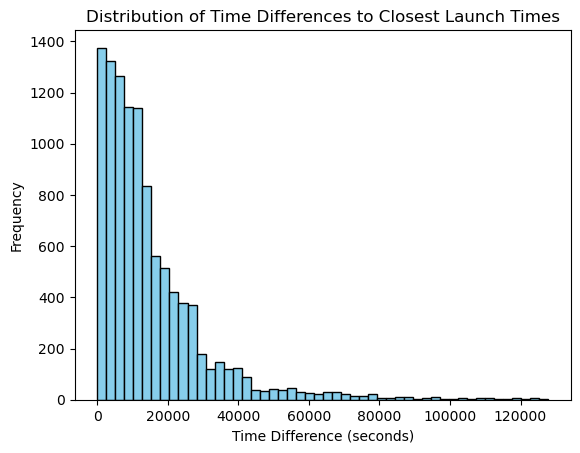

Minimum time difference: 1 seconds
Maximum time difference: 127848 seconds
Median time difference: 10627 seconds


In [95]:
import matplotlib.pyplot as plt

# Calculate the time differences for each epoch_time in RU_PNT_SAT_copy to the closest time_start or time_end
time_diffs = []
for epoch_time in RU_PNT_SAT_copy['epoch']:
    # Calculate differences
    df_missile_cleaned['time_diff_start'] = (df_missile_cleaned['time_start'] - epoch_time).abs()
    df_missile_cleaned['time_diff_end'] = (df_missile_cleaned['time_end'] - epoch_time).abs()
    
    # Get the minimum time difference for each epoch_time
    min_time_diff = min(df_missile_cleaned['time_diff_start'].min(), df_missile_cleaned['time_diff_end'].min())
    time_diffs.append(min_time_diff)

# Plot the distribution of time differences
plt.hist(time_diffs, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Time Differences to Closest Launch Times")
plt.show()

# Display the minimum, maximum, and median time differences
min_diff = min(time_diffs)
max_diff = max(time_diffs)
median_diff = sorted(time_diffs)[len(time_diffs) // 2]
print(f"Minimum time difference: {min_diff} seconds")
print(f"Maximum time difference: {max_diff} seconds")
print(f"Median time difference: {median_diff} seconds")

In [98]:
# Ensure time_start and time_end in df_missile_cleaned are integers (Unix timestamps in seconds)
df_missile_cleaned['time_start'] = df_missile_cleaned['time_start'].astype(int)
df_missile_cleaned['time_end'] = df_missile_cleaned['time_end'].astype(int)

# Define a function to find the closest launch time (either start or end) and retrieve both differences
def closest_launch_info(epoch_time):
    # Calculate the time differences from both start and end times relative to epoch_time
    df_missile_cleaned['diff_from_start'] = epoch_time - df_missile_cleaned['time_start']
    df_missile_cleaned['diff_from_end'] = epoch_time - df_missile_cleaned['time_end']
    
    # Calculate the absolute differences for comparison
    df_missile_cleaned['abs_diff_from_start'] = df_missile_cleaned['diff_from_start'].abs()
    df_missile_cleaned['abs_diff_from_end'] = df_missile_cleaned['diff_from_end'].abs()
    
    # Find the closest time (start or end)
    closest_start_idx = df_missile_cleaned['abs_diff_from_start'].idxmin()
    closest_end_idx = df_missile_cleaned['abs_diff_from_end'].idxmin()
    
    # Determine the closest launch and retrieve differences
    closest_launch = df_missile_cleaned.loc[closest_start_idx if df_missile_cleaned.loc[closest_start_idx, 'abs_diff_from_start'] <= df_missile_cleaned.loc[closest_end_idx, 'abs_diff_from_end'] else closest_end_idx]
    
    return pd.Series(
        [closest_launch['diff_from_start'], closest_launch['diff_from_end'], closest_launch['time_start'], closest_launch['time_end'], closest_launch['model'], closest_launch['target'], closest_launch['launched']],
        index=['diff_from_start', 'diff_from_end', 'launch_time_start', 'launch_time_end', 'launch_model', 'launch_target', 'launch_count']
    )

# Step 1: Apply closest_launch_info for OPTICS_anomaly
optics_output = RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'epoch'].apply(closest_launch_info)

# Assign each column separately to avoid the `.tolist()` issue
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'optics_diff_from_start'] = optics_output['diff_from_start']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'optics_diff_from_end'] = optics_output['diff_from_end']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'optics_launch_time_start'] = optics_output['launch_time_start']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'optics_launch_time_end'] = optics_output['launch_time_end']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'optics_launch_model'] = optics_output['launch_model']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'optics_launch_target'] = optics_output['launch_target']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['OPTICS_anomaly'] == True, 'optics_launch_count'] = optics_output['launch_count']

# Step 2: Apply closest_launch_info for statistical_thresholding_anomaly
stat_output = RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'epoch'].apply(closest_launch_info)

# Assign each column separately for stat_output as well
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'stat_threshold_diff_from_start'] = stat_output['diff_from_start']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'stat_threshold_diff_from_end'] = stat_output['diff_from_end']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'stat_threshold_launch_time_start'] = stat_output['launch_time_start']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'stat_threshold_launch_time_end'] = stat_output['launch_time_end']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'stat_threshold_launch_model'] = stat_output['launch_model']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'stat_threshold_launch_target'] = stat_output['launch_target']
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['statistical_thresholding_anomaly'] == True, 'stat_threshold_launch_count'] = stat_output['launch_count']

# Convert seconds to HH:MM:SS format
def convert_to_hhmmss(seconds):
    if pd.notnull(seconds):  # Convert only if seconds is not NaN
        return str(timedelta(seconds=int(seconds)))
    return seconds  # Return NaN or the original value if it's NaN

# Apply the conversion function to diff_from_start and diff_from_end for both anomaly types
for prefix in ['optics', 'stat_threshold']:
    RU_PNT_SAT_copy[f'{prefix}_diff_from_start'] = RU_PNT_SAT_copy[f'{prefix}_diff_from_start'].apply(convert_to_hhmmss)
    RU_PNT_SAT_copy[f'{prefix}_diff_from_end'] = RU_PNT_SAT_copy[f'{prefix}_diff_from_end'].apply(convert_to_hhmmss)

# Display the relevant columns for review
anomalies_df = RU_PNT_SAT_copy[['datetime_stamp', 'epoch', 'optics_diff_from_start', 'optics_diff_from_end', 
                                'optics_launch_time_start', 'optics_launch_time_end', 'optics_launch_model', 
                                'optics_launch_target', 'optics_launch_count', 'stat_threshold_diff_from_start', 
                                'stat_threshold_diff_from_end', 'stat_threshold_launch_time_start', 
                                'stat_threshold_launch_time_end', 'stat_threshold_launch_model', 
                                'stat_threshold_launch_target', 'stat_threshold_launch_count', 
                                'satNo', 'semiMajorAxis', 'inclination', 'meanMotion', 'statistical_thresholding_anomaly', 'OPTICS_anomaly']]

anomalies_df.head(20)


datetime_stamp       epoch optics_diff_from_start optics_diff_from_end  optics_launch_time_start  optics_launch_time_end optics_launch_model                     optics_launch_target  optics_launch_count stat_threshold_diff_from_start stat_threshold_diff_from_end  stat_threshold_launch_time_start  stat_threshold_launch_time_end stat_threshold_launch_model         stat_threshold_launch_target  stat_threshold_launch_count  satNo  semiMajorAxis  inclination  meanMotion statistical_thresholding_anomaly OPTICS_anomaly
29711 2024-01-21 00:52:42.563136+00:00  1705798362                0:52:42      -1 day, 0:53:42              1.705795e+09            1.705882e+09                X-59      Dnipropetrovsk oblast, Dnipro Raion                  1.0                            NaN                          NaN                               NaN                             NaN                         NaN                                  NaN                          NaN  29671       3.339854    -0.264236   -3.340327                            False           True
29712 2024-09-30 08:13:07.427712+00:00  1727683987                    NaN                  NaN                       NaN                     NaN                 NaN                                      NaN                  NaN                       13:13:07                      0:13:07                      1.727636e+09                    1.727683e+09                   X-59/X-69                              Ukraine                          1.0  29671       3.336018    -0.277893   -3.336651                             True          False
29713 2024-09-28 08:47:51.707616+00:00  1727513271                    NaN                  NaN                       NaN                     NaN                 NaN                                      NaN                  NaN                            NaN                          NaN                               NaN                             NaN                         NaN                                  NaN                          NaN  29671       3.336977    -0.277738   -3.337570                            False          False
29714 2024-09-26 14:38:55.265568+00:00  1727361535                    NaN                  NaN                       NaN                     NaN                 NaN                                      NaN                  NaN                            NaN                          NaN                               NaN                             NaN                         NaN                                  NaN                          NaN  29671       3.337616    -0.277272   -3.338157                            False          False
29715 2024-02-16 10:01:08.580288+00:00  1708077668       -1 day, 16:01:08     -1 day, 16:01:08              1.708106e+09            1.708106e+09                X-59  Dnipropetrovsk oblast, Kryvyi Rih Raion                  1.0                            NaN                          NaN                               NaN                             NaN                         NaN                                  NaN                          NaN  29671       3.339534    -0.265478   -3.340021                            False           True
29716 2024-03-16 21:55:42.604320+00:00  1710626142       -1 day, 21:55:42     -1 day, 13:55:42              1.710634e+09            1.710662e+09                X-59                         Chernihiv oblast                  2.0               -1 day, 21:55:42             -1 day, 13:55:42                      1.710634e+09                    1.710662e+09                        X-59                     Chernihiv oblast                          2.0  29671       3.339215    -0.267340   -3.339791                             True           True
29717 2024-03-10 08:05:42.873792+00:00  1710057942                    NaN                  NaN                       NaN                     NaN                 NaN                                      NaN                  NaN    

In [106]:
RU_PNT_SAT_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10617 entries, 29711 to 2951509
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   idElset                           10617 non-null  object             
 1   classificationMarking             10617 non-null  object             
 2   satNo                             10617 non-null  int32              
 3   datetime_stamp                    10617 non-null  datetime64[ns, UTC]
 4   meanMotion                        10617 non-null  float64            
 5   idOnOrbit                         10617 non-null  object             
 6   eccentricity                      10617 non-null  float64            
 7   inclination                       10617 non-null  float64            
 8   raan                              10617 non-null  float64            
 9   argOfPerigee                      10617 non-null  float64   

In [110]:
# Export the updated DataFrame to an csv file
RU_PNT_SAT_copy.to_csv('RU_PNT_SAT_final.csv', index=False)

In [105]:
# Print the total number of anomalies for each case
total_stat_true = anomalies_df[anomalies_df['statistical_thresholding_anomaly'] == True].shape[0]
total_optics_true = anomalies_df[anomalies_df['OPTICS_anomaly'] == True].shape[0]
total_both_true = anomalies_df[(anomalies_df['statistical_thresholding_anomaly'] == True) & 
                               (anomalies_df['OPTICS_anomaly'] == True)].shape[0]

print(f"Total number of anomalies where statistical_thresholding_anomaly is True: {total_stat_true}")
print(f"Total number of anomalies where OPTICS_anomaly is True: {total_optics_true}")
print(f"Total number of anomalies where both anomalies are True: {total_both_true}")

# Initialize counters for correlated attacks within 6 hours for each case
correlated_case_1 = 0
correlated_case_2 = 0
correlated_case_3 = 0

# Define hour thresholds in seconds
hour_thresholds = [3600 * i for i in range(1, 7)]  # 1 hour, 2 hours, ..., 6 hours

# Loop through each threshold and print combined counts for each of the three cases
for i, threshold in enumerate(hour_thresholds, start=1):
    print(f"\nThreshold: {i} hour(s) ({threshold} seconds)")
    
    # Case 1: statistical_thresholding_anomaly is True and OPTICS_anomaly is False
    case_1 = anomalies_df[(anomalies_df['statistical_thresholding_anomaly'] == True) & 
                          (anomalies_df['OPTICS_anomaly'] == False)]
    count_within_threshold_case_1 = case_1[
        (case_1['stat_threshold_diff_from_start'] <= f"{i}:00:00") | 
        (case_1['stat_threshold_diff_from_end'] <= f"{i}:00:00")
    ].shape[0]
    print(f"Case 1 - Stat True, OPTICS False: Total within {i} hour(s): {count_within_threshold_case_1}")
    
    # Track correlated attacks within 6 hours
    if i == 6:
        correlated_case_1 = count_within_threshold_case_1
    
    # Case 2: OPTICS_anomaly is True and statistical_thresholding_anomaly is False
    case_2 = anomalies_df[(anomalies_df['statistical_thresholding_anomaly'] == False) & 
                          (anomalies_df['OPTICS_anomaly'] == True)]
    count_within_threshold_case_2 = case_2[
        (case_2['optics_diff_from_start'] <= f"{i}:00:00") | 
        (case_2['optics_diff_from_end'] <= f"{i}:00:00")
    ].shape[0]
    print(f"Case 2 - OPTICS True, Stat False: Total within {i} hour(s): {count_within_threshold_case_2}")
    
    # Track correlated attacks within 6 hours
    if i == 6:
        correlated_case_2 = count_within_threshold_case_2
    
    # Case 3: Both statistical_thresholding_anomaly and OPTICS_anomaly are True
    case_3 = anomalies_df[(anomalies_df['statistical_thresholding_anomaly'] == True) & 
                          (anomalies_df['OPTICS_anomaly'] == True)]
    count_within_threshold_case_3 = case_3[
        (case_3['optics_diff_from_start'] <= f"{i}:00:00") | 
        (case_3['optics_diff_from_end'] <= f"{i}:00:00")
    ].shape[0]
    print(f"Case 3 - Both anomalies True: Total within {i} hour(s): {count_within_threshold_case_3}")
    
    # Track correlated attacks within 6 hours
    if i == 6:
        correlated_case_3 = count_within_threshold_case_3

# Calculate accuracy for each case within the 6-hour window
accuracy_case_1 = correlated_case_1 / total_stat_true if total_stat_true > 0 else 0
accuracy_case_2 = correlated_case_2 / total_optics_true if total_optics_true > 0 else 0
accuracy_case_3 = correlated_case_3 / total_both_true if total_both_true > 0 else 0

# Print accuracy results
print("\nAccuracy Results:")
print(f"Accuracy for Case 1 - Stat True, OPTICS False: {accuracy_case_1:.2%}")
print(f"Accuracy for Case 2 - OPTICS True, Stat False: {accuracy_case_2:.2%}")
print(f"Accuracy for Case 3 - Both anomalies True: {accuracy_case_3:.2%}")


Total number of anomalies where statistical_thresholding_anomaly is True: 4659
Total number of anomalies where OPTICS_anomaly is True: 3837
Total number of anomalies where both anomalies are True: 1854

Threshold: 1 hour(s) (3600 seconds)
Case 1 - Stat True, OPTICS False: Total within 1 hour(s): 2586
Case 2 - OPTICS True, Stat False: Total within 1 hour(s): 1814
Case 3 - Both anomalies True: Total within 1 hour(s): 1688

Threshold: 2 hour(s) (7200 seconds)
Case 1 - Stat True, OPTICS False: Total within 2 hour(s): 2716
Case 2 - OPTICS True, Stat False: Total within 2 hour(s): 1911
Case 3 - Both anomalies True: Total within 2 hour(s): 1797

Threshold: 3 hour(s) (10800 seconds)
Case 1 - Stat True, OPTICS False: Total within 3 hour(s): 2740
Case 2 - OPTICS True, Stat False: Total within 3 hour(s): 1939
Case 3 - Both anomalies True: Total within 3 hour(s): 1818

Threshold: 4 hour(s) (14400 seconds)
Case 1 - Stat True, OPTICS False: Total within 4 hour(s): 2761
Case 2 - OPTICS True, Stat Fal

Next Actions to add...
Plot over map physical location the during the anomaly windows (David)